# Introdução

**Autor: Jackson Souza Corrêa**

LikedIn: https://www.linkedin.com/in/jackson-corr%C3%AAa/

GitHub: https://github.com/JacksonSCorrea

##Importação de bibliotecas

In [ ]:
# Instalação de bibliotecas
!pip install category_encoders

# Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from category_encoders import CatBoostEncoder

import pickle

import warnings
warnings.filterwarnings("ignore")

##Definição de funções

###Metadados

In [ ]:
# Função de Metadados
def report_data(df, **kwargs):

  '''
  Função que cria um dataframe resumo de valores missing e outliers no dataframe original
  Argumento obrigatório: dataframe
  Argumento opcional: k (valor do fator de multiplicação para o cálculo do limite de outliers)
  '''

  df2 = pd.DataFrame()
  df2['Feature'] = list(df.columns)
  df2['Tipo'] = df.dtypes.values
  df2['Card'] = df.nunique().values
  df2['qtd miss'] = df.isnull().sum().values
  df2['%Miss'] = round(100 * df2['qtd miss'] / df.shape[0] , 1)


  Q1 = df.quantile(0.25)    #primeiro quartil (percentil 25)
  Q3 = df.quantile(0.75)    #terceiro quartil (percentil 75)
  IIQ = Q3 - Q1             #intervalo interquartil
  k = kwargs.get('k', 1.5)  #Fator multiplicador
  LS = Q3 + k*IIQ           #Limite superior
  LI = Q1 - k*IIQ           #Limite inferior

  df2['qtd out sup'] = df[df.select_dtypes(include=['float64', 'int64', 'float32' , 'int32'])>LS].count().values
  df2['%Out_sup'] = round(100 * df2['qtd out sup'] / df.shape[0] , 1)


  df2['qtd out inf'] = df[df.select_dtypes(include=['float64', 'int64', 'float32' , 'int32'])<LI].count().values
  df2['%Out_inf'] = round(100 * df2['qtd out inf'] / df.count().values , 1)

  df2['qtd outliers'] = df2['qtd out sup'] + df2['qtd out inf']
  df2['%Outliers'] = round(100 * df2['qtd outliers'] / df.count().values , 1)


  # Inicialize um DataFrame vazio para armazenar as modas e suas frequências percentuais
  moda_e_frequencia = pd.DataFrame(columns=['Moda', 'Frequência Percentual'])

  # Itere sobre as colunas do DataFrame
  for coluna in df.columns:
      moda = df[coluna].mode().values[0]  # Encontre a moda da coluna
      frequencia = (df[coluna] == moda).mean() * 100  # Calcule a frequência percentual
      moda_e_frequencia = moda_e_frequencia.append({'Moda': moda, '%Freq': round(frequencia,1)}, ignore_index=True)

  df2['Moda'] = moda_e_frequencia['Moda']
  df2['%Freq'] = moda_e_frequencia['%Freq']


  # Quantidade de variáveis com valores faltantes:
  qtd_miss = df2.loc[df2['qtd miss']!= 0,'qtd miss'].count()

  # Quantidade de features numéricas e categóricas
  qtd_numerica = sum(list(df2.loc[(df2['Tipo']=='float') | (df2['Tipo']=='int32')|(df2['Tipo']=='int64'),['Feature']].count()))
  qtd_categorica = sum(list(df2.loc[df2['Tipo']=='object' , ['Feature']].count()))

  # Cálculo da cardinalidade total das variáveis categóricas
  qtd_card_tot = sum(list(df2.loc[(df2['Tipo']=='object') , ['Card']].sum()))

  # Cálculo da quantidade de linhas duplicadas
  dup = df.duplicated().sum()

  # Estilo ANSI para negrito e amarelo
  amarelo = "\033[1;33m"

  # Resetar estilo ANSI (para evitar que o texto seguinte também seja vermelho)
  resetar_estilo = "\033[0m"

  print(f'''{amarelo}
  Quantidade de linhas duplicadas: {dup}  |  Quantidade de features com valores faltantes: {qtd_miss}
  Quantidade de features numéricas: {qtd_numerica}  |  Quantidade de features categóricas {qtd_categorica}
  Cardinalidade total das categóricas: {qtd_card_tot}  |  Dataframe: {df.shape[0]} linhas, {df.shape[1]} colunas
        {resetar_estilo}''')

  # Dropa colunas desnecessárias
  df2.drop(['qtd miss','qtd out sup' , 'qtd out inf', 'qtd outliers'], axis=1 , inplace=True)


  return df2

###Dataprep out-of-sample

In [ ]:
def dataprep_out_of_sample(df, target, col_id , metadados, **kwargs):


  #----------------------------------------------------------------------------------------------
  # Argumentos opcionais
  #----------------------------------------------------------------------------------------------

  lim_miss = kwargs.get('lim_miss', 70)
  lim_card = kwargs.get('lim_card', 20)
  convert_target = kwargs.get('convert_target', False)
  encoder_method = kwargs.get('encoder_method', None)
  scaled = kwargs.get('scaled', False)
  stratify = kwargs.get('stratify', 'no')
  # cat_input = kwargs.get('cat_input', 'sem_info')
  random_state = kwargs.get('random_state', 42)


  #----------------------------------------------------------------------------------------------
  # Variáveis de entrada da função
  #----------------------------------------------------------------------------------------------

  # df              = tabela analítica de modelagem inicial que será ajustada em uma nova tabela

  # target          = nome da coluna que contém a target

  # col_id          = nome da coluna que contém os ID's. Se não houver ID', passar como 'None'

  # metadados       = metadados da tabela analítica de modelagem inicial

  # convert_target  = True, se for aplicar LabelEncoder na Target, ou False, caso contrário.

  # lim_miss        = limite percentual de valores nulos para dropagem da coluna

  # lim_card        = limite de cardinalidade para utilização do encoder:
  #                   - colunas com cardinalidade menor ou igual ao valor: utilizado OneHotEnconder;
  #                   - colunas com cardinalidade maior que o valor: utilizado LabelEncoder;
  #                   - valor só é útil se o encoder especificado for 'onehot+label'.

  # encoder_method  = método que irá fazer a codificação das variáveis categóricas:
  #                   - 'onehot+label': OneHotEncoder nas de baixa card. e LabelEncoder nas de alta car;
  #                   - 'catboost': CatBoostEncoder em todas as variáveis;
  #                   - None: Não aplica encoder em nenhuma variável categórica (se houver).

  # scaled          = Informa quais variáveis serão padronizadas:
  #                   - False: nenhuma variável;
  #                   - True: todas as variáveis;
  #                   - 'num': se houver variáveis categóricas, será aplicado nas originalmente numéricas.

  # stratify        = Informa se o split de dados de treino/teste será estratificado em relação à tareget

  # cat_input       = Valor para imputação das categóricas com valores nulos

  # random_state    = valor paraa semente aleatória para split dos dados de treino e teste


  #----------------------------------------------------------------------------------------------
  # Descrição
  #----------------------------------------------------------------------------------------------

  # Função para automação da etapa de preparação dos dados
  # Esta função salva as diversas etapas de transformação dos
  # dados de treino (X_train) e de teste (X_test).
  # A função também retorna todos os conjuntos de dados e os artefatos
  # utilizados na transformação, como os encoders, o scaler, as medianas imputadas, etc


  #----------------------------------------------------------------------------------------------
  # Exemplo de uso
  #----------------------------------------------------------------------------------------------

  # dataprep_01 = dataprep_out_of_time(df=abt_00, target='Default', metadados=metadados_00,
  #                                     lim_miss=70, lim_card=20, scaled=False,
  #                                     encoder_method='onehot+label', convert_target=False)


  #----------------------------------------------------------------------------------------------
  # Separando dados de treino e teste antes de qualquer manipulação - evitar DataLeakage
  #----------------------------------------------------------------------------------------------

  # Importando o pacote
  from sklearn.model_selection import train_test_split

  # Divisão X e Y
  X = df.drop(target, axis=1)
  y = df[target]

  # Divisão treino e teste
  if stratify=='no':
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)                  #sem estratificação
  elif stratify == 'yes':
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)      #estratifica pela target


  #----------------------------------------------------------------------------------------------
  # Salvando backup das colunas com os dados de ID's
  #----------------------------------------------------------------------------------------------

  # Se não foi informada a coluna de ID's...
  if col_id == None:

    # Armazena uma string nao invés dos ID's
    col_id_train = 'Não informado'
    col_id_test = 'Não informado'


  # Se a coluna de ID's foi informada...
  else:

    # Backup da coluna onde estão os ID's dos dados de treino e dos dados de teste
    col_id_train = X_train[col_id]   #treino
    col_id_test = X_test[col_id]     #teste

    # Dropando a coluna de ID's dos dados de treino e dos dados de teste
    X_train.drop(col_id, axis=1, inplace=True)   #treino
    X_test.drop(col_id, axis=1, inplace=True)    #teste


  #----------------------------------------------------------------------------------------------
  # Dropando colunas com alto percentual de missing
  #----------------------------------------------------------------------------------------------

  # Limites
  lim_miss = lim_miss

  # Lista de variáveis com miss acima do limiar
  list_var_drop = list(metadados.loc[metadados['%Miss'] > lim_miss, 'Feature'])

  # Dropando em X_train
  X_train.drop(list_var_drop, axis=1, inplace=True)

  # Dropando em X_test
  X_test.drop(list_var_drop, axis=1, inplace=True)


  #----------------------------------------------------------------------------------------------
  # Definindo colunas numéricas e categóricas
  #----------------------------------------------------------------------------------------------

  num_var = list(X_train.select_dtypes(include=('int32','int64','float')).columns)
  cat_var = list(X_train.select_dtypes(include='object').columns)


  #----------------------------------------------------------------------------------------------
  # Imputando valores
  #----------------------------------------------------------------------------------------------

  # Dicionário vazio para armazenar os inputs de miss
  list_miss_input = {}

  # Iterando pelas colunas numéricas
  for i in num_var:
    # Verificando se existe valor nulo na coluna
    if X_train[i].isna().any() == True:
      mediana = X_train[i].median()                   #Econtra a mediana a partir dos daods de treino
      X_train[i].fillna(mediana , inplace=True)       #Imputa a mediana nos dados de treino
      X_test[i].fillna(mediana , inplace=True)        #Imputa a mediana nos dados de teste
      list_miss_input[i] = mediana                    #Acrescenta o par chave/valor ao dicionário

  # Iterando pelas colunas categóricas
  for i in cat_var:
    # Verificando se existe valor nulo na coluna
      X_train[i].fillna('sem info' , inplace=True)    #Imputa a mediana nos dados de treino
      X_test[i].fillna('sem info' , inplace=True)     #Imputa a mediana nos dados de teste
      list_miss_input[i] = 'sem info'                 #Acrescenta o par chave/valor ao dicionário
      # Observação:
      # não imputar strings com "underline"
      # para não afetar no rastrei das dummies
      # que possuem o sufixo '_dummy'


  #----------------------------------------------------------------------------------------------
  # Codificação da target
  #----------------------------------------------------------------------------------------------

  # Importando o pacote
  from sklearn.preprocessing import LabelEncoder

  if convert_target == True:      #Caso a target precise ser convertida
    # Instanciando
    encoder_target = LabelEncoder()

    # Aplicando treino e teste
    y_train = encoder_target.fit_transform(y_train)     #Fit e transform
    y_test = encoder_target.transform(y_test)           #Apenas transform

  elif convert_target == False:   # Caso a target não precise ser convertida
    encoder_target = 'Não aplicado'


  #----------------------------------------------------------------------------------------------
  # Codificação de variáveis categóricas
  #----------------------------------------------------------------------------------------------

  # Caso não seja aplicado nenhum encoder nas variáveis
  if encoder_method == None:
      X_train_enc = 'Não aplicado'
      X_test_enc = 'Não aplicado'

  #Caso seja aplicado algum encoder nas variáveis
  else:

      # Copiando
      X_train_enc = X_train.copy()
      X_test_enc = X_test.copy()

      # Limite de cardinalidade para aplicar um ou outro encoder
      lim_card = lim_card

      # Separando variáveis de alta e baixa cardinalidade
      alta_card = list(X_train[cat_var].columns[X_train[cat_var].nunique() > lim_card])
      baixa_card = list(X_train[cat_var].columns[X_train[cat_var].nunique() <= lim_card])

      # Se foi definido OneHotEncoder + LabelEncoder
      if encoder_method == 'onehot+label':

          # Importando os pacotes
          from sklearn.preprocessing import LabelEncoder, OneHotEncoder

          # Instanciando - Label Encoder nas de alta cardinalidade
          # >>> Necessário fazer um loop para salvar o Encoder de cada feature numa lista
          # >>> Label encoder não dá pra aplicar em mais de uma Feature
          label_encoder = LabelEncoder()

          # Inicializa um dicionário para salvaro label encoder de cada coluna
          dict_label_encoder = {}

          # Label encoder - alta cardinalidade
          for i in alta_card:
              X_train_enc[i] = label_encoder.fit_transform(X_train_enc[i]) #Fit_transform nos dados de treino
              X_test_enc[i] = label_encoder.transform(X_test_enc[i])       #Somente transform nos dados de teste
              dict_label_encoder[i] = label_encoder                        #Salva o encoder. A chave é a coluna i, e o valor é o encoder

          # Crie e aplique o OneHotEncoder
          OneHot_encoder = OneHotEncoder(sparse=False, drop='first')

          # Aplicando OneHotEncoding nos conjuntos de treino e teste
          encoded_data = OneHot_encoder.fit_transform(X_train_enc[baixa_card]) #Fit_transform nos dados de treino

          # Criando dataframe com as colunas codificadas, mantendo o índice original
          encoded_cols = OneHot_encoder.get_feature_names_out(baixa_card)
          encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols + '_dummy', index=X_train_enc.index)

          # Concatenando o dataframe codificado com o dataframe original em X_train
          X_train_enc = pd.concat([X_train_enc.drop(baixa_card, axis=1), encoded_df], axis=1)

          # Aplicando OneHotEncoding em X_test
          encoded_data = OneHot_encoder.transform(X_test_enc[baixa_card]) #Somente transform nos dados de teste

          # Criando dataframe com as colunas codificadas, mantendo o índice original
          encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols + '_dummy', index=X_test_enc.index)

          # Concatenando o dataframe codificado com o dataframe original em X_test
          X_test_enc = pd.concat([X_test_enc.drop(baixa_card, axis=1), encoded_df], axis=1)

      # Se foi definido Catboost
      elif encoder_method == 'catboost':

          # Importando o pacote
          from category_encoders import CatBoostEncoder

          # Instanciando
          cat_encoder = CatBoostEncoder(cols=cat_var)

          # Aplicando as transformações
          X_train_enc = cat_encoder.fit_transform(X_train_enc, y_train)  #fit.transform
          X_test_enc = cat_encoder.transform(X_test_enc)                 #somente "transform"


  #----------------------------------------------------------------------------------------------
  # Padronização dos dados (não precisa para árvores)
  #----------------------------------------------------------------------------------------------

  # Importando o pacote
  from sklearn.preprocessing import StandardScaler

  # Se foi selecionado algum encoder para categorizar as variáveis
  if encoder_method != None:

      # Criando cópia dos dados categorizados
      X_train_enc_std = X_train_enc.copy()
      X_test_enc_std = X_test_enc.copy()

      # Instanciando
      scaler = StandardScaler()

      # Se foi selecionado que o scaler será aplicado somente nas colunas originalmente numéricas
      # Ou seja, encoder nas categóricas + scaler nas numéricas
      if scaled == 'num':
          qtd_scaler = len(num_var)  # Quantidade de variáveis (igual a quantidade de numéricas) ao qual foi aplicado o scaler
          list_var_scaled = num_var  # Lista de variáveis que passarão pelo scaler, que é a lista de variáveis originalmente numéricas
          X_train_enc_std[num_var] = scaler.fit_transform(X_train_enc_std[num_var])  # Aplica fit_transform nos dados de treino
          X_test_enc_std[num_var] = scaler.transform(X_test_enc_std[num_var])        # Somente transform nos dados de teste

      # Se foi selecionado que o scaler será aplicado em todas as colunas (numéricas e categóricas) (após o encoder das categóricas)
      # Ou seja, encoder nas categóricas + scaler em todas
      elif scaled == True:
          qtd_scaler = len(list(X_train_enc.columns))         # Quantidade de variáveis da base categorizada ao qual foi aplicado o scaler
          list_var_scaled = list(X_train_enc.columns)         # Lista de variáveis da base categorizada que passarão pelo scaler
          X_train_enc_std = pd.DataFrame(scaler.fit_transform(X_train_enc), columns=X_train_enc.columns)  # Aplica fit_transform nos dados de treino
          X_test_enc_std = pd.DataFrame(scaler.transform(X_test_enc), columns=X_test_enc.columns)         # ASomente transform nos dados de teste

      # Se foi selecionado que não será aplicado scaler em nenhuma variável
      # Ou seja, somente encoder nas categóricas e sem scaler em nada
      elif scaled == False:
        scaler = 'Não aplicado'
        qtd_scaler = 'Não aplicado'
        list_var_scaled = 'Não aplicado'
        X_train_enc_std = 'Não aplicado'
        X_test_enc_std = 'Não aplicado'


  # Se não foi selecionado nenhum encoder, também não deixa padronizar nada <<<
  # Ou seja, não aplica nem encoder nas categóricas, >>> e nem scaler em nada <<<
  elif encoder_method == None:

      # Criando cópia para os dados padronizados
      X_train_enc_std = X_train.copy() # Nota: o termo "_enc_" foi mantido apenas
      X_test_enc_std = X_test.copy()   # para que não se tenha necessidade de
                                       # ajustar mais o código mas, na verdade
                                       # esses dados não passaram por encoder
                                       # e foram copiados diretamente
                                       # de X_train e X_test. Nesse caso, nas linhas
                                       # acima, X_train_enc e X_test_enc já receberam
                                       # o valor "Não aplicado"

      # Se foi selecionado que o scaler será aplicado somente nas numéricas. Nesse caso, se não houver categóricas, todas as features serão padronizadas
      # Ou seja, sem encoder em nenhuma categórica + scaler em todas as numéricas
      if scaled == 'num':
          qtd_scaler = len(list(X_train.columns))  # Quantidade de variáveis ao qual foi aplicado o scaler
          list_var_scaled = list(X_train.columns)  # Lista de variáveis que passarão pelo scaler
          X_train_enc_std = pd.DataFrame(scaler.fit_transform(X_train_enc), columns=X_train_enc.columns)  # Aplica fit_transform nos dados de treino
          X_test_enc_std = pd.DataFrame(scaler.transform(X_test_enc), columns=X_test_enc.columns)         # ASomente transform nos dados de teste

      # Se foi selecionado que não será aplicado scaler em nenhuma variável
      # Ou seja, nem encoder nas categóricas e nem scaler em nada
      elif scaled == False:
        scaler = 'Não aplicado'
        qtd_scaler = 'Não aplicado'
        list_var_scaled = 'Não aplicado'
        X_train_enc_std = 'Não aplicado'
        X_test_enc_std = 'Não aplicado'



  #----------------------------------------------------------------------------------------------
  # Objetos finais
  #----------------------------------------------------------------------------------------------

  # Se não foi usado nenhum encoder
  if encoder_method == None:

      one_hot_enc = 'Não aplicado'
      label_enc = 'Não aplicado'
      catboost_enc = 'Não aplicado'
      list_var_OneHotEncoder = 'Não aplicado'
      list_var_LabelEncoder = 'Não aplicado'
      list_var_CatBoostEncoder = 'Não aplicado'

      # Resumo
      resume = f'''Resumo dataprep:\n
      • Limite de percentual de nulos adotado: {lim_miss}%
      • Quantidade de variáveis dropadas por nulos: {len(list_var_drop)}
      • Quantidade de variáveis ao qual foi aplicado OneHotEncoder: Não aplicado
      • Quantidade de variáveis ao qual foi aplicado LabelEncoder: Não aplicado
      • Quantidade de variáveis ao qual foi aplicado CatBoostEncoder: Não aplicado
      • Quantidade de variáveis ao qual foi aplicado StandardScaler: Não aplicado'''

  # Se foi utilizado OneHotEncoder + LabelEncoder
  elif encoder_method == 'onehot+label':

      one_hot_enc = OneHot_encoder
      label_enc = dict_label_encoder
      catboost_enc = 'Não aplicado'
      list_var_OneHotEncoder = baixa_card
      list_var_LabelEncoder = alta_card
      list_var_CatBoostEncoder = 'Não aplicado'

      # Resumo
      resume = f'''Resumo dataprep:\n
      • Limite de cardinalidade adotado: {lim_card}
      • Limite de percentual de nulos adotado: {lim_miss}%
      • Quantidade de variáveis dropadas por nulos: {len(list_var_drop)}
      • Quantidade de variáveis ao qual foi aplicado OneHotEncoder: {len(baixa_card)}
      • Quantidade de variáveis ao qual foi aplicado LabelEncoder: {len(alta_card)}
      • Quantidade de variáveis ao qual foi aplicado StandardScaler: {qtd_scaler}'''

  # Se foi utilizado CatboostEncoder
  elif encoder_method == 'catboost':

      one_hot_enc = 'Não aplicado'
      label_enc = 'Não aplicado'
      catboost_enc = cat_encoder
      list_var_OneHotEncoder = 'Não aplicado'
      list_var_LabelEncoder = 'Não aplicado'
      list_var_CatBoostEncoder = cat_var

      # Resumo
      resume = f'''Resumo dataprep:\n
      • Limite de cardinalidade adotado: {lim_card}
      • Limite de percentual de nulos adotado: {lim_miss}%
      • Quantidade de variáveis dropadas por nulos: {len(list_var_drop)}
      • Quantidade de variáveis ao qual foi aplicado CatBoostEncoder: {len(cat_var)}
      • Quantidade de variáveis ao qual foi aplicado StandardScaler: {qtd_scaler}'''



  class DataPrepResult:
      def __init__(self, X_train, X_train_enc, X_train_enc_std, X_test,
                    X_test_enc, X_test_enc_std, y_train, y_test, scaler,
                    list_var_OneHotEncoder, list_var_LabelEncoder, list_var_CatBoostEncoder,
                    list_var_scaled, list_var_drop, list_miss_input,
                    one_hot_enc, label_enc, catboost_enc, encoder_target,
                    col_id_train , col_id_test, resume):

          self.X_train = X_train
          self.X_train_enc = X_train_enc
          self.X_train_enc_std = X_train_enc_std
          self.X_test = X_test
          self.X_test_enc = X_test_enc
          self.X_test_enc_std = X_test_enc_std
          self.y_train = y_train
          self.y_test = y_test
          self.scaler = scaler
          self.list_var_OneHotEncoder = list_var_OneHotEncoder
          self.list_var_LabelEncoder = list_var_LabelEncoder
          self.list_var_CatBoostEncoder = list_var_CatBoostEncoder
          self.list_var_scaled = list_var_scaled
          self.list_var_drop = list_var_drop
          self.list_miss_input = list_miss_input
          self.one_hot_enc = one_hot_enc
          self.label_enc = label_enc
          self.catboost_enc = catboost_enc
          self.encoder_target = encoder_target
          self.col_id_train = col_id_train
          self.col_id_test = col_id_test
          self.resume = resume



  return DataPrepResult(X_train, X_train_enc, X_train_enc_std, X_test,
                        X_test_enc, X_test_enc_std, y_train, y_test, scaler,
                        list_var_OneHotEncoder, list_var_LabelEncoder, list_var_CatBoostEncoder,
                        list_var_scaled, list_var_drop, list_miss_input,
                        one_hot_enc, label_enc, catboost_enc, encoder_target,
                        col_id_train , col_id_test, resume)


###Cálculo de métricas de classificação

In [ ]:
def calculate_metrics(model_name, model, X_train, y_train, X_test, y_test):

    # Fazendo predições
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculando as métricas para o conjunto de treino
    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    auc_roc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])  #Na coluna de indice 1 está a probabilidade de o evento ser 1

    # Calculando o Índice Gini e Estatística KS para o conjunto de treino
    probabilities_train = model.predict_proba(X_train)[:, 1]
    df_train = pd.DataFrame({'true_labels': y_train, 'predicted_probs': probabilities_train})
    df_train = df_train.sort_values(by='predicted_probs', ascending=False)
    df_train['cumulative_true'] = df_train['true_labels'].cumsum() / df_train['true_labels'].sum()
    df_train['cumulative_false'] = (1 - df_train['true_labels']).cumsum() / (1 - df_train['true_labels']).sum()
    ks_statistic_train = max(abs(df_train['cumulative_true'] - df_train['cumulative_false']))
    gini_index_train = 2 * auc_roc_train - 1    #Cálculo do Gini

    # Calculando as métricas para o conjunto de teste
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    auc_roc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]) #Na coluna de indice 1 está a probabilidade de o evento ser 1

    # Calculando o Índice Gini e Estatística KS para o conjunto de teste
    probabilities_test = model.predict_proba(X_test)[:, 1]
    df_test = pd.DataFrame({'true_labels': y_test, 'predicted_probs': probabilities_test})
    df_test = df_test.sort_values(by='predicted_probs', ascending=False)
    df_test['cumulative_true'] = df_test['true_labels'].cumsum() / df_test['true_labels'].sum()
    df_test['cumulative_false'] = (1 - df_test['true_labels']).cumsum() / (1 - df_test['true_labels']).sum()
    ks_statistic_test = max(abs(df_test['cumulative_true'] - df_test['cumulative_false']))
    gini_index_test = 2 * auc_roc_test - 1    #Cálculo do Gini

    # Criando o DataFrame com as métricas calculadas
    metrics_df = pd.DataFrame({
        'Algoritmo': [model_name, model_name],
        'Conjunto': ['Treino', 'Teste'],
        'Acuracia': [accuracy_train, accuracy_test],
        'Precisao': [precision_train, precision_test],
        'Recall': [recall_train, recall_test],
        'AUC_ROC': [auc_roc_train, auc_roc_test],
        'GINI': [gini_index_train, gini_index_test],
        'KS': [ks_statistic_train, ks_statistic_test]
    })

    return metrics_df

###Plotagem de métricas de classificação

In [ ]:
def plot_metrics(model, X_train, y_train, X_test, y_test):

    features = np.array(X_train.columns)

    plt.figure(figsize=(15, 18))

    # Ajusta o layout
    plt.tight_layout(pad=5, h_pad=8)

    # Gráfico de Barras para Taxa do Evento e Importância das Variáveis
    plt.subplot(4, 2, 1)
    event_rate = y_train.mean()
    non_event_rate = 1 - event_rate
    plt.barh(['Não Evento', 'Evento'], [non_event_rate, event_rate], color=['lightsteelblue', 'skyblue'])
    plt.xlabel('Taxa')
    plt.title('Taxa do Evento')

    plt.subplot(4, 2, 2)
    importances = model.feature_importances_
    indices = np.argsort(importances)  # Ordem ascendente
    indices = indices[-10:]  # Considerando apenas as 10 mais importantes
    plt.barh(features[indices], importances[indices], color='skyblue')
    plt.xlabel('Importância')
    plt.title('Importância das Variáveis')

    # Curva ROC para Treino e Teste
    plt.subplot(4, 2, 3)
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')

    # Gráfico de Barras para Gini e KS
    plt.subplot(4, 2, 4)
    metrics = ['Índice Gini', 'Estatística KS']
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        probs = model.predict_proba(X)[:, 1]
        df = pd.DataFrame({'true_labels': y, 'predicted_probs': probs})
        df = df.sort_values(by='predicted_probs', ascending=False)
        df['cumulative_true'] = df['true_labels'].cumsum() / df['true_labels'].sum()
        df['cumulative_false'] = (1 - df['true_labels']).cumsum() / (1 - df['true_labels']).sum()
        ks = max(abs(df['cumulative_true'] - df['cumulative_false']))
        gini = 2 * auc(*roc_curve(y, probs)[:2]) - 1
        plt.bar([f'{label}\n{metric}' for metric in metrics], [gini, ks], color='skyblue')
    plt.title('Índice Gini e Estatística KS')

    # Matrizes de Confusão para Treino e Teste
    for i, (X, y, label) in enumerate([(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')], 5):
        plt.subplot(4, 2, i)
        conf_matrix = confusion_matrix(y, model.predict(X))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Matriz de Confusão - {label}')

    # Histograma do Score para Treino e Teste
    plt.subplot(4, 2, 7)
    plt.hist(model.predict_proba(X_train)[:, 1], bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='Treino')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Treino')
    plt.legend(loc='upper right')

    plt.subplot(4, 2, 8)
    plt.hist(model.predict_proba(X_test)[:, 1], bins=30, color='lightsteelblue', edgecolor='black', alpha=0.7, label='Teste')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Teste')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

###Ordena Scores

In [ ]:
def ordena_score(model, name_model, X_train, X_test, y_train, y_test, n_bins):



  # model = rf_opt
  # name_model = 'Decision Tree'

  fix, ax = plt.subplots(1,2,figsize=(14, 6))

  # Previsão das probabilidades no conjunto de treino
  probabilidades = model.predict_proba(X_train)[:, 1]

  # Adiciona um pequeno ruído às probabilidades
  noise = np.random.uniform(0, 0.0001, size=probabilidades.shape)
  probabilidades += noise

  # Cria um DataFrame com as probabilidades e as respostas reais
  df = pd.DataFrame({'Probabilidades': probabilidades, 'Resposta Real': y_train})

  # Classifica o DataFrame com base nas probabilidades
  df = df.sort_values(by='Probabilidades', ascending=False)

  # Calcula os deciles
  df['Deciles'] = pd.qcut(df['Probabilidades'], q=n_bins, labels=False, duplicates='drop')

  # Calcula a taxa de evento em cada decile
  # Pega a média dos scores que foram agrupados em cada faixa
  decile_analysis = df.groupby('Deciles')['Resposta Real'].mean().reset_index()

  # Plota o gráfico de barras com os deciles e a taxa de evento
  ax[0].bar(decile_analysis['Deciles'], decile_analysis['Resposta Real'], color='steelblue')
  ax[0].set_title('Ordenação do Score - Treino - ' + name_model)
  ax[0].set_xlabel('Faixas de Score')
  ax[0].set_ylabel('Taxa de Evento')



  # Previsão das probabilidades no conjunto de teste
  probabilidades = model.predict_proba(X_test)[:, 1]

  # Adiciona um pequeno ruído às probabilidades
  noise = np.random.uniform(0, 0.0001, size=probabilidades.shape)
  probabilidades += noise

  # Cria um DataFrame com as probabilidades e as respostas reais
  df = pd.DataFrame({'Probabilidades': probabilidades, 'Resposta Real': y_test})

  # Classifica o DataFrame com base nas probabilidades
  df = df.sort_values(by='Probabilidades', ascending=False)

  # Calcula os deciles
  df['Deciles'] = pd.qcut(df['Probabilidades'], q=n_bins, labels=False, duplicates='drop')

  # Calcula a taxa de evento em cada decile
  # Pega a média dos scores que foram agrupados em cada faixa
  decile_analysis = df.groupby('Deciles')['Resposta Real'].mean().reset_index()

  # Plota o gráfico de barras com os deciles e a taxa de evento

  ax[1].bar(decile_analysis['Deciles'], decile_analysis['Resposta Real'], color='darkorange')
  ax[1].set_title('Ordenação do Score - Teste - ' + name_model)
  ax[1].set_xlabel('Faixas de Score')
  ax[1].set_ylabel('Taxa de Evento')


  plt.show()

###Plotagens de gráficos

In [ ]:
def plot_scatter(df, x_var, y_var, figsize, **kwargs):

    '''Função para plotar o gráfico de dispersão entre variáveis'''

    # Extraindo os argumentos opcionais e atribuindo os valores default
    color = kwargs.get('color', 'deepskyblue')
    marker = kwargs.get('marker', 'o')
    label_size = kwargs.get('label_size', 11)
    grid = kwargs.get('grid', False)

    # Gráfico
    fig, ax = plt.subplots(figsize=figsize)

    sns.scatterplot(data=df, x=x_var, y=y_var, color=color, marker=marker, ax=ax)

    ax.set_title(f'Scatter Plot entre "{x_var}" e "{y_var}"', pad=30, fontdict={'fontsize': 12, 'weight': 'bold'})
    ax.set_xlabel(x_var, fontsize=9)
    ax.set_ylabel(y_var, fontsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='y', labelsize=label_size)
    ax.grid(grid)

    plt.xticks(rotation=0)
    plt.yticks(rotation=0)

    plt.show()

# =======================================================================================================================

def plot_hist(df, var, figsize, **kwargs):

    '''Função para plotar o histgrama de uma variável'''

    # Extraindo os argumentos opcionais e atribuindo os valores default
    color = kwargs.get('color', 'deepskyblue')

    bins = kwargs.get('bins', 30)  # Número de bins no histograma

    pad = kwargs.get('pad', 30)

    label_size = kwargs.get('label_size', 9)

    txt_rot = kwargs.get('txt_rot', 'v')

    stat = kwargs.get('stat', 'frequency')

    grid = kwargs.get('grid', False)


    if txt_rot == 'h':
        rotation = 0
    elif txt_rot == 'v':
        rotation = 90
    else:
        rotation = txt_rot

    # Gráfico
    fig, ax = plt.subplots(figsize=figsize)

    sns.histplot(data=df, x=var, bins=bins, color=color, ax=ax)

    ax.set_title(f'Histograma da variável "{var}"', pad=pad, fontdict={'fontsize': 12, 'weight': 'bold'})
    ax.set_xlabel(var,  fontsize=9)
    ax.set_ylabel(stat, fontsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', labelsize=label_size)
    ax.tick_params(axis='y', labelsize=label_size)
    ax.grid(grid)

    plt.xticks(rotation=rotation)

    plt.show()

# =======================================================================================================================

def plot_bar(df, var, figsize, **kwargs):
    '''
    Função para plotar o gráfico de barras de uma única variável
    Pode ser entendido como o gráfico de distribuição das categorias de uma variável
    '''

    import textwrap  # Importe a função textwrap

    df_aux = df.copy()
    df_aux[var] = df_aux[var].astype(str)

    # Adicione os argumentos opcionais "top" e "ascending"
    ascending = kwargs.get('ascending', False)
    top = kwargs.get('top', None)

    df_grouped = df_aux.groupby(var).size().sort_values(ascending=ascending)

    tot = df_grouped.sum()
    x = df_grouped.index

    mode = kwargs.get('mode', 'percent')
    cutoff = kwargs.get('corte', None)  # Novo argumento para o ponto de corte
    unity = kwargs.get('unity', '')

    if cutoff is not None:
        if mode == 'percent':
            cutoff_value = tot * (cutoff / 100)
            small_categories = df_grouped[df_grouped < cutoff_value].index
            df_grouped[f'Outros\n(<{cutoff}%)'] = df_grouped[small_categories].sum()
            df_grouped.drop(small_categories, inplace=True)
            x = df_grouped.index
        elif mode == 'absolute':  # Handle cutoff for 'absolute' mode
            small_categories = df_grouped[df_grouped < cutoff].index
            df_grouped[f'Outros\n(<{cutoff}{unity})'] = df_grouped[small_categories].sum()
            df_grouped.drop(small_categories, inplace=True)
            x = df_grouped.index

    color = kwargs.get('color', 'deepskyblue')
    decimals = kwargs.get('decimals', 1)
    pad = kwargs.get('pad', 30)
    dist = kwargs.get('dist', 1)
    label_font = kwargs.get('label_height', 9)
    txt_rot = kwargs.get('txt_rot', 'h')
    title = kwargs.get('title', f'Variável "{var}"')


    if mode == 'percent':
        # Ajuste das proporções de acordo com o corte
        y = 100 * (df_grouped.values / df_grouped.values.sum())
        ylabel = 'Percentual (%)'
    elif mode == 'absolute':
        y = df_grouped.values
        ylabel = 'Número Absoluto'
    else:
        raise ValueError("O modo de exibição deve ser 'percent' ou 'absolute'.")

    if top is not None:
        # Exibir apenas as 10 primeiras barras, mas ajustar as proporções
        x = x[:top]
        y = y[:top]

    if txt_rot == 'h':
        rotation = 0
    elif txt_rot == 'v':
        rotation = 90
    else:
        rotation = txt_rot

    sns.set_style("ticks")

    fig, ax = plt.subplots(figsize=figsize)

    # Use a função textwrap.fill para formatar os rótulos do eixo X
    x = [textwrap.fill(label, 15) for label in x]

    sns.barplot(x=x, y=y, color=color, alpha=1)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_yticklabels(ax.get_yticklabels(), visible=False)
    ax.set_title(f'{title}', pad=pad, fontdict={'fontsize': 12, 'weight': 'bold'})
    ax.set_xlabel('')
    ax.set_ylabel(ylabel)
    plt.gca().set_yticks([])
    plt.gca().set_ylabel('')
    ax.tick_params(axis='x', labelsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    for i, v in enumerate(y):
        if mode == 'percent':
            display_value = str(round(v, decimals)) + " %"
        elif mode == 'absolute':
            display_value = str(int(v))
        ax.text(i, v + dist, display_value + ' ' + unity, ha='center', va='bottom', fontsize=label_font, rotation=rotation)

    plt.show()


# =======================================================================================================================

def plot_bar_2var(df, var_x, var_y, figsize, **kwargs):
    '''
    Função para plotar o gráfico de barras entre duas variáveis
    Recebe como entrada as variáveis dos eixos X e Y
    '''

    df_aux = df.copy()

    df_aux[var_x] = df_aux[var_x].astype(str)
    df_aux[var_y] = df_aux[var_y].astype(float)

    # Adicione os argumentos opcionais "top" e "ascending"
    ascending = kwargs.get('ascending', False)
    top = kwargs.get('top', None)

    # Ordene o DataFrame com base no parâmetro "ascending"
    df_aux = df_aux.sort_values(by=var_y, ascending=ascending)

    # Aplicar o argumento "top" se especificado
    if top is not None:
        df_aux = df_aux.head(top)

    x = df_aux[var_x].tolist()
    y = df_aux[var_y].tolist()

    color = kwargs.get('color', 'deepskyblue')
    decimals = kwargs.get('decimals', 1)
    pad = kwargs.get('pad', 30)
    dist = kwargs.get('dist', 1)
    label_font = kwargs.get('label_height', 9)
    txt_rot = kwargs.get('txt_rot', 'h')
    title = kwargs.get('title', f'Gráfico de Barras de "{var_x}" por "{var_y}"')
    unity = kwargs.get('unity', '')

    if txt_rot == 'h':
        rotation = 0
    elif txt_rot == 'v':
        rotation = 90
    else:
        rotation = txt_rot

    sns.set_style("ticks")

    fig, ax = plt.subplots(figsize=figsize)

    sns.barplot(x=x, y=y, color=color, alpha=1)

    ax.set_title(f'{title}', pad=pad, fontdict={'fontsize': 12, 'weight': 'bold'})

    ax.set_xlabel(var_x)
    plt.gca().set_yticks([])
    plt.gca().set_ylabel('')
    ax.tick_params(axis='x', labelsize=9)
    ax.tick_params(axis='y', labelsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    for i, v in enumerate(y):
        display_value = str(round(v, decimals))
        ax.text(i, v + dist, display_value + unity, ha='center', va='bottom', fontsize=label_font, rotation=rotation)

    plt.xticks(rotation=90)

    plt.show()


# =======================================================================================================================

def plot_batch_boxplot(dataframe, **kwargs):
    """
    Plota boxplots estilizados com título simplificado para todas as
    variáveis numéricas do dataframe fornecido em um painel com gráficos
    configurados por linhas e colunas.

    :param dataframe: DataFrame para o qual os boxplots serão gerados.
    :param cols: Número de colunas no painel de gráficos (opcional, padrão é 3).
    :param num_size: Tamanho dos rótulos do eixo y de cada subplot (opcional, padrão é 11).
    :param color: Cor dos subplots (opcional, padrão é 'skyblue').
    :param b: largura do subplot (opcional, padrão é 15).
    """
    # Argumentos opcionais
    cols = kwargs.get('cols', 3)
    label_size = kwargs.get('label_size', 9)
    color = kwargs.get('color', 'deepskyblue')
    b = kwargs.get('b', 15)

    # Seleciona apenas colunas numéricas
    numeric_columns = dataframe.select_dtypes(include=['float64', 'int64']).columns

    # Calcula número de linhas
    nrows = len(numeric_columns) // cols + (len(numeric_columns) % cols > 0)

    # Inicializa o painel de gráficos
    fig, axes = plt.subplots(nrows=nrows, ncols=cols, figsize=(b, nrows * 5))

    # Ajusta o layout
    plt.tight_layout(pad=5, h_pad=8)

    # Configura estilo e paleta de cores
    sns.set_style("whitegrid")

    # Plota boxplots para cada coluna numérica
    for i, column in enumerate(numeric_columns):
        ax = axes[i // cols, i % cols]
        sns.boxplot(data=dataframe[column], ax=ax, color=color)
        ax.set_title(f'{column}', fontdict={'fontsize': 12, 'fontweight': 'bold'})
        ax.set_ylabel('')
        ax.tick_params(axis='both', which='major', labelsize=label_size)
        if label_size:
            ax.tick_params(axis='y', labelsize=label_size)

    # Remove gráficos vazios (se houver)
    for j in range(i + 1, nrows * cols):
        fig.delaxes(axes.flatten()[j])

    # Adiciona título principal
    fig.suptitle("Análise descritiva - BoxPlot", fontsize=16, fontweight='bold', y=1.005)

# =======================================================================================================================

def plot_batch_histogram(dataframe, **kwargs):
    """
    Plota histogramas estilizados com título simplificado para todas as
    variáveis numéricas do dataframe fornecido em um painel com gráficos
    configurados por linhas e colunas.

    :param dataframe: DataFrame para o qual os histogramas serão gerados.
    :param cols: Número de colunas no painel de gráficos (opcional, padrão é 3).
    :param label_size: Tamanho dos rótulos do eixo y de cada subplot (opcional, padrão é 9).
    :param color: Cor dos subplots (opcional, padrão é 'deepskyblue').
    :param kde: Se True, ativa KDE nos histogramas; se False, desativa (opcional, padrão é False).
    :param bins: Número de bins nos histogramas (opcional, padrão é 30).
    :param stat: Se 'percent', mostra o percentual de cada categoria; se 'frequency', mostra a frequência absoluta (opcional, padrão é 'frequency').
    :param grid: Se True, exibe o grid nos gráficos; se False, não exibe (opcional, padrão é False).
    """
    # Argumentos opcionais
    cols = kwargs.get('cols', 3)
    label_size = kwargs.get('label_size', 9)
    color = kwargs.get('color', 'deepskyblue')
    kde = kwargs.get('kde', False)
    bins = kwargs.get('bins', 30)
    stat = kwargs.get('stat', 'frequency')
    grid = kwargs.get('grid', False)
    b = kwargs.get('b', 15)
    hue = kwargs.get('hue', None)

    # Seleciona apenas colunas numéricas
    numeric_columns = dataframe.select_dtypes(include=['float64', 'int64']).columns

    # Calcula número de linhas
    nrows = len(numeric_columns) // cols + (len(numeric_columns) % cols > 0)

    # Inicializa o painel de gráficos
    fig, axes = plt.subplots(nrows=nrows, ncols=cols, figsize=(b, nrows * 5))

    # Ajusta o layout
    plt.tight_layout(pad=5, h_pad=8)

    # Configura estilo e paleta de cores
    sns.set_style("whitegrid")

    # Plota histogramas para cada coluna numérica
    for i, column in enumerate(numeric_columns):
        ax = axes[i // cols, i % cols]

        # Verificando se foi definida a variável semântica (hue)
        if hue == None:
          sns.histplot(data=dataframe[column], ax=ax, color=color, kde=kde, bins=bins, stat=stat)
        else:
          # sns.histplot(data=dataframe , x=column, ax=ax, color=color, kde=True, element='step', bins=bins, stat=stat, hue=hue)
          sns.kdeplot(data=dataframe, x=column,  ax=ax , fill=True , hue=hue)

        ax.set_title(f'{column}', fontdict={'fontsize': 12, 'fontweight': 'bold'})
        ax.set_ylabel(stat)
        ax.tick_params(axis='both', which='major', labelsize=label_size)
        if label_size:
            ax.tick_params(axis='y', labelsize=label_size)
            ax.tick_params(axis='x', labelrotation=90)
            ax.get_yaxis().get_major_formatter().set_scientific(False)  # Formatação para números não em notação científica
        ax.grid(grid)

    # Remove gráficos vazios (se houver)
    for j in range(i + 1, nrows * cols):
        fig.delaxes(axes.flatten()[j])

    # Adiciona título principal
    fig.suptitle("Análise descritiva - Histograma", fontsize=16, fontweight='bold', y=1.005)

    # Configuração para desativar o grid
    if not grid:
        ax.grid(False)

    # Exibe os gráficos
    plt.show()

# =======================================================================================================================

def plot_batch_scatter(dataframe, y_variable, **kwargs):
    """
    Plota scatter plots para todas as variáveis numéricas do dataframe fornecido,
    em relação a uma variável específica fornecida como y_variable.

    :param dataframe: DataFrame para o qual os scatter plots serão gerados.
    :param y_variable: Nome da variável que será usada como eixo y nos scatter plots.
    :param cols: Número de colunas no painel de gráficos (opcional, padrão é 3).
    :param num_size: Tamanho dos rótulos do eixo y de cada subplot (opcional, padrão é 11).
    :param color: Cor dos subplots (opcional, padrão é 'skyblue').
    :param marker: Marcador para os pontos no scatter plot (opcional, padrão é 'o').
    :param grid: Se True, ativa o grid nos scatter plots; se False, desativa (opcional, padrão é True).
    """
    # Argumentos opcionais
    cols = kwargs.get('cols', 3)
    label_size = kwargs.get('label_size', 9)
    color = kwargs.get('color', 'deepskyblue')
    marker = kwargs.get('marker', 'o')
    grid = kwargs.get('grid', False)
    b = kwargs.get('b', 15)

    # Seleciona apenas colunas numéricas
    numeric_columns = dataframe.select_dtypes(include=['float64', 'int64']).columns

    # Calcula número de linhas
    nrows = len(numeric_columns) // cols + (len(numeric_columns) % cols > 0)

    # Inicializa o painel de gráficos
    fig, axes = plt.subplots(nrows=nrows, ncols=cols, figsize=(b, nrows * 5))

    # Ajusta o layout
    plt.tight_layout(pad=5, h_pad=8)

    # Configura estilo e paleta de cores
    sns.set_style("whitegrid")

    # Plota scatter plots para cada coluna numérica
    for i, column in enumerate(numeric_columns):
        ax = axes[i // cols, i % cols]
        sns.scatterplot(x=dataframe[column], y=dataframe[y_variable], ax=ax, color=color, marker=marker)
        ax.set_title(f'{column} X {y_variable}', fontdict={'fontsize': 12, 'fontweight': 'bold'})
        ax.set_xlabel(column)
        ax.set_ylabel(y_variable)
        ax.tick_params(axis='both', which='major', labelsize=label_size)
        if label_size:
            ax.tick_params(axis='y', labelsize=label_size)
        ax.grid(grid)

    # Remove gráficos vazios (se houver)
    for j in range(i + 1, nrows * cols):
        fig.delaxes(axes.flatten()[j])

    # Adiciona título principal
    fig.suptitle(f"Análise de Scatter Plots - {y_variable}", fontsize=16, fontweight='bold', y=1.005)

    # Configuração para desativar o grid
    if not grid:
        ax.grid(False)

# =======================================================================================================================


def plot_batch_bar(dataframe, card_max, **kwargs):
    """
    Plota gráficos de barras para todas as variáveis categóricas do dataframe fornecido,
    desde que o número de categorias seja menor ou igual a card_max.

    :param dataframe: DataFrame para o qual os gráficos serão gerados.
    :param card_max: Número máximo de categorias para exibir os gráficos de barras.
    :param cols: Número de colunas no painel de gráficos (opcional, padrão é 2).
    :param num_size: Tamanho dos rótulos do eixo y de cada subplot (opcional, padrão é 11).
    :param color: Cor dos subplots (opcional, padrão é 'deepskyblue').
    :param stat: Se 'percent', mostra o percentual de cada categoria; se 'frequency', mostra a frequência absoluta (opcional, padrão é 'percent').
    :param grid: Se True, exibe o grid nos gráficos; se False, não exibe (opcional, padrão é True).
    :param ascending: Se True, ordena as categorias em ordem crescente; se False, em ordem decrescente (opcional, padrão é False).
    """

    # Argumentos opcionais
    n_cols = kwargs.get('cols', 2)
    num_size = kwargs.get('num_size', 11)
    color = kwargs.get('color', 'deepskyblue')
    stat = kwargs.get('stat', 'percent')
    grid = kwargs.get('grid', True)
    label_size = kwargs.get('label_size', 9)
    b = kwargs.get('b', 15)
    h_pad = kwargs.get('h_pad', 8)

    # Filtra as colunas categóricas com até card_max categorias
    categorical_columns = [col for col in dataframe.columns if dataframe[col].dtype == 'object' or dataframe[col].dtype.name == 'category']

    # Calcula o número de linhas com base no número de colunas
    n_rows = (len(categorical_columns) + n_cols - 1) // n_cols

    # Configuração do tamanho da figura
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(b, n_rows * 5))

    # Ajusta o layout
    plt.tight_layout(pad=5, h_pad=h_pad)

    # Configuração do estilo e paleta de cores
    sns.set_style("whitegrid")

    # Plota gráficos de barras para cada coluna categórica
    for i, column in enumerate(categorical_columns):
        ax = axes[i // n_cols, i % n_cols]

        # Filtra as categorias com até card_max categorias
        counts = dataframe[column].value_counts()

        # Calcula o percentual em relação a todas as categorias
        counts_percent = (counts / counts.sum() * 100).sort_values(ascending=False)

        # Verifica se card_max é definido e, se for, pega as 30 maiores categorias
        if card_max is not None:
            counts_percent = counts_percent.head(card_max)

        if stat == 'percent':
            counts_percent.plot(kind='bar', ax=ax, color=color)
            ax.set_ylabel('Percentual (%)')
        else:
            counts.plot(kind='bar', ax=ax, color=color)
            ax.set_ylabel('Frequência Absoluta')
            ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))  # Formata os valores do eixo Y

        ax.set_title(f'{column}', fontdict={'fontsize': 11, 'fontweight': 'bold'})
        ax.set_xlabel('')
        ax.tick_params(axis='both', which='major', labelsize=11)
        ax.tick_params(axis='x', labelrotation=90)  # Rotação de 90 graus nos rótulos do eixo X
        ax.tick_params(axis='x', labelsize=label_size)
        ax.tick_params(axis='y', labelsize=label_size)
        ax.grid(grid)

        # Quebra de linha nos rótulos do eixo X
        ax.set_xticklabels([textwrap.fill(str(label), 20) for label in counts_percent.index], fontsize=9)

    # Remove gráficos vazios (se houver)
    for j in range(len(categorical_columns), n_rows * n_cols):
        fig.delaxes(axes.flatten()[j])

    # Adiciona título principal
    fig.suptitle("Análise descritiva - Gráfico de Barras", fontsize=16, fontweight='bold', y=1.005)

    # Exibe os gráficos
    plt.show()

###Feature Selection por Feature Importance (Árvores)

In [ ]:
def fs_importance(model, X, y, cutoff_importance, plot, figsize=None, model_name=None):

  # Treinamento
  model.fit(X, y)

  # Extraindo a importância das variáveis
  feature_importances = model.feature_importances_
  features = pd.DataFrame({ 'Feature': X.columns, 'Importance': feature_importances })

  # Ordenar variáveis por importância
  features = features.sort_values(by='Importance', ascending=False)

  # Estabelecer um limite de corte, por exemplo, x% da importância máxima
  cutoff_maximp = cutoff_importance

  cutoff = cutoff_maximp * feature_importances.max()

  # Selecionar variáveis acima do corte
  selected_features = X.columns[feature_importances >= cutoff].tolist()

  # Selecionar variáveis abaixo do corte
  not_selected_features = X.columns[feature_importances < cutoff].tolist()

  # Visualizando a importância das variáveis em barras horizontais
  if figsize==None:
    plt.figure(figsize=(10, 6))
  else:
    plt.figure(figsize=figsize)

  sorted_idx = feature_importances.argsort()

  print(f'\nFeatures removidas: {len(not_selected_features)}')

  print(f'Features remanescentes: {len(selected_features)}\n')

  lim_plot = 60 #Limite de variáveis para plotar o gráfico

  if plot==True: #and len(features) <= lim_plot:
    plt.barh(X.columns[sorted_idx], feature_importances[sorted_idx], color='dodgerblue')  # tom de azul claro
    plt.xlabel("Feature Importance")
    if model_name == None:
      plt.title(f"Feature Importance")
    else:
      plt.title(f"Feature Importance com {model_name}")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.axvline(x=cutoff, color='r', linestyle='--', label=f'Ponto de corte = {100*cutoff_maximp:.1f} %\nda importância máxima')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
  else:
    print(f'\033[1;33mO gráfico não será exibido pois a quantidade total de features é maior que {lim_plot}.\033[0m\n')

  return selected_features

###Feature selection por Information Value

In [ ]:
# Feature selection com IV Values
  # Utilizado quando se tem target binário
  # Recomendado ser implementado num conjunto já reduzido
  # por uma etapa preliminar de feature selection
  # Pode captar variáveis preditoras "Fracas", que passaram pelas
  # etapas anteriores. Assim, pode-se removê-las diretamente nesta etapa
  # ou voltar á etapa anterior e "apertar" o funil (que é a sugestão)

# Função para discretizar as variáveis numéricas
def discretize_numeric_features(df, bins):
    df_discretized = df.copy()
    for col in df.columns:
        if df[col].dtype in ['float64', 'float32', 'int64', 'int32'] and len(df[col].unique()) > bins:
            df_discretized[col] = pd.cut(df[col], bins=bins, labels=False, duplicates='drop')
    return df_discretized

# Função para calcular o IV de uma variável já discretizada
def calculate_iv(df, feature, target):
    lst = []
    for value in df[feature].unique():
        lst.append({
            'Value': value,
            'All': df[df[feature] == value].count()[feature],
            'Good': df[(df[feature] == value) & (df[target] == 1)].count()[feature],
            'Bad': df[(df[feature] == value) & (df[target] == 0)].count()[feature]
        })

    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = (dset['Good'] + 0.0001) / (dset['Good'].sum() + 0.0001)  # Adding a small value to avoid division by zero
    dset['Distr_Bad'] = (dset['Bad'] + 0.0001) / (dset['Bad'].sum() + 0.0001)  # Adding a small value to avoid division by zero
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad']).replace({np.inf: 0, -np.inf: 0})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    return dset['IV'].sum()


# Função que avalia e retorna o IV da variável
def classify_iv(iv_value):
    if iv_value < 0.02:
        return "Muito Fraco"
    elif iv_value < 0.1:
        return "Fraco"
    elif iv_value < 0.3:
        return "Moderado"
    elif iv_value < 0.5:
        return "Forte"
    else:
        return "Muito Forte"

# Função que chama todas as outras e cria um dataframe com a IV de cada variável
# Observação passar o dataframe inteiro (ao invés de só as explicativas) e especificar a target
def select_features_by_iv_discretized(df, target, iv_cutoff_ratio=1.0, bins=10):
    from tqdm import tqdm
    df = discretize_numeric_features(df, bins)

    iv_stats = []
    for col in tqdm(df.columns, desc="Calculating IV", unit="variable"):
        if col != target:
            iv_value = calculate_iv(df, col, target)
            iv_stats.append({
                'Variable': col,
                'IV': iv_value,
                'Predictiveness': classify_iv(iv_value)
            })

    iv_df = pd.DataFrame(iv_stats).sort_values(by='IV', ascending=False)
    max_iv = iv_df['IV'].max()
    cutoff_value = iv_cutoff_ratio * max_iv
    selected_features = iv_df[iv_df['IV'] >= cutoff_value]['Variable'].tolist()

    return selected_features, iv_df

###Feature selection por PCA

In [ ]:
def fs_pca(X , variance_explained , features_per_component):

  # Feature selection com redução de dimensionalidade através do PCA
  # Método não supervisionado
  # Não indicado para quando existe a target (modelo ou análise de dados)

  from sklearn.decomposition import PCA

  # Percentual da variância que os compentes devem ser capazes de explicar
  variance = variance_explained

  # Número de features mais representativas em cada componente
  n=features_per_component

  # Instanciando - Mantendo componentes que expliquem 95% da variância do modelo
  pca = PCA(n_components = variance)

  # Treinando
  pca.fit(X)

  # Obtém os autovetores (componentes principais) e a variância explicada
  eigen_vectors = pca.components_
  explained_variance = pca.explained_variance_ratio_

  # Cria um DataFrame para armazenar as informações
  result_df = pd.DataFrame()

  # Loop através dos autovetores (componentes)
  for i in range(len(eigen_vectors)):
      # Obtém as cargas absolutas dos componentes do autovetor atual
      component_loadings = np.abs(eigen_vectors[i])

      # Ordena os índices das variáveis em ordem decrescente de carga
      sorted_indices = np.argsort(component_loadings)[::-1][:n]

      # Obtém o nome das n variáveis de maior carga
      top_n_variable_names = X.columns[sorted_indices].tolist()

      # Cria um dicionário com as informações
      info = {'Componente': f'Componente {i + 1}',
          'Vari. Expl.': explained_variance[i],}

      for j, var_name in enumerate(top_n_variable_names, start=1):
          info[f'Feature {j}'] = var_name

      # Adiciona as informações ao DataFrame
      result_df = result_df.append(info, ignore_index=True)

  # Exibe o DataFrame resultante
  result_df

  # Extrai e exibe as features selecionadas
  list_var_pca = result_df.iloc[:,2:].values
  list_var_pca = list(set(item for array in list_var_pca for item in array))

  return list_var_pca, result_df

###Feature selection por variância e correlação

In [ ]:
def fs_variance_and_correlation(X , y , model, threshold_variance, threshold_correlation):

  # Dropagem de features com baixa variância e features altamente correlacionadas

  # ------------------------------------------------------------------------------------------------------
  # Dropando features de baixa variância

  # Definindo o limiar (queremos manter as variáveis que têm uma variância superior ao valor definido)
  # Se colocar valor 0 (zero) apenas variáveis constantes serão descartadas
  threshold = threshold_variance
  selector = VarianceThreshold(threshold)

  # Aplicando transformação (já remove as variáveis)
  selector.fit_transform(X)

  # Lista de colunas selecionadas
  selected_features = X.columns[selector.get_support()]
  discarded_features = X.columns[~selector.get_support()]

  # Eliminando
  X.drop(discarded_features , axis = 1, inplace = True)


  # ------------------------------------------------------------------------------------------------------
  # Dropando features altamente correlacionadas
  # Este algoritmo identifica as features correlacionadas e mantém aquela que ocasionará
  # o melhor desempenho do modelo. Existe um outra biblioteca (DropCorrelatedFeatures)
  # que elimina apenas as features correlacionadas, sem identificar aquela de melhor
  # desempenho no modelo

  # Instanciando validação cruzada estratificada
  # skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # shuffle=False --> Não embaralha // random_state=None --> sem semente para embaralhamento

  # Instanciando
  # smart_corr_selection = SmartCorrelatedSelection(method='pearson',threshold=0.75,selection_method='model_performance',estimator=RandomForestClassifier(random_state=42),cv=skf)
  smart_corr_selection = SmartCorrelatedSelection(method='pearson', threshold = threshold_correlation,
                                                  selection_method='model_performance',
                                                  estimator = model, cv=5 )

  # Aplicando transformação (já remove as variáveis)
  X = smart_corr_selection.fit_transform(X , y)

  # Lista de features remanescentes
  remaining_features_corr = list(X.columns)

  # Lista de features removidas
  droped_features_corr = list(smart_corr_selection.features_to_drop_)

  print(f'\nFeatures de baixa variância removidas: {len(discarded_features)}')

  print(f'Features de alta correlação removidas: {len(droped_features_corr)}')

  print(f'Features remanescentes: {len(remaining_features_corr)}\n')

  return remaining_features_corr

###Feature selection por Boruta

In [ ]:
def fs_boruta(X, y):

  # Feature selection com Boruta
  # recomendado Processar em lotes
  # Exemplo: 2 lotes de 5 mil variáveis / 4 lotes de 2500 variáveis...
  # ... Juntar as que sobraram e fazer uma rodada final
  # Ajustar de acordo com a velocidade que se deseja para o processamento
  # Outra alternativa e rodar iterativamente o Boruta
  # Não é necessário definir explicitamente um limiar de importância ao usar o Boruta.
  # O algoritmo faz essa escolha internamente com base na lógica de
  # comparação entre as características reais e as de sombra (shadow).

  model = RandomForestClassifier()

  # Define o método Boruta
  feat_selector = BorutaPy(model , n_estimators='auto', verbose=0, random_state=42)

  # Executa o Boruta
  feat_selector.fit(X.values, y)

  # Obtém as variáveis selecionadas
  selected_features_boruta = X.columns[feat_selector.support_].tolist()

  # Obtenha as características não selecionadas
  features_not_selected = X.columns[~feat_selector.support_].tolist()

  return selected_features_boruta

###Feature selection por Eliminação Recursiva (RFE)

In [ ]:
def fs_rfe(X , y , model, n_vars_keep):
  # Funciona para um escopo pequeno de variáveis
  # Sugestão: até 1000 variáveis

  # Eliminação recursiva de features

  # Total de features
  tot = len(list(X.columns))

  # Instancie o RFE e selecione 2 variáveis
  n_vars_keep = n_vars_keep

  # Instancie o RFE
  rfe = RFE(estimator=model, n_features_to_select=n_vars_keep)
  fit = rfe.fit(X, y)

  selected_features_rfe = list(X.columns[fit.support_])


  print(f'\nFeatures removidas: {tot-n_vars_keep}')

  print(f'Features remanescentes: {n_vars_keep}\n')


  return selected_features_rfe

#Business Understanding

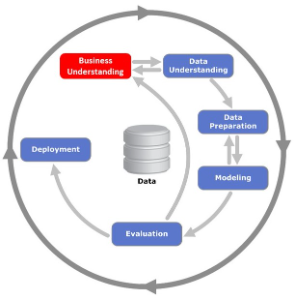

**Contexto:**

O Banco Prospex, instituição bancária portuguesa, deseja melhorar sua eficácia nas campanhas de marketing para depósitos bancários a prazo. Para atingir esse objetivo, você deve desenvolver um modelo preditivo capaz de prever a propensão dos clientes à subscrição desse produto.

<br>

**Descrição do Problema:**

O problema em questão é a falta de direcionamento eficiente nas campanhas de marketing para depósitos bancários a prazo. Atualmente, a abordagem de marketing é ampla e pouco personalizada, o que resulta em baixas taxas de conversão e uso ineficaz de recursos.

<br>

**Desafio de Negócio:**

Seu desafio é criar um modelo de propensão de compra de depósito bancário a prazo que permita à instituição prever quais clientes têm maior probabilidade de adquirir esse produto. O objetivo é:

* Desenvolver um modelo de aprendizado de máquina capaz de prever a propensão de um cliente à subscrição do produto com base em seus atributos e histórico.

* Identificar os principais fatores que influenciam a decisão dos clientes de subscreverem ou não um depósito bancário a prazo com base nas informações disponíveis.

* Utilizar o modelo para classificar os clientes em grupos de alta, média e baixa propensão, permitindo que a equipe de marketing direcione seus esforços de maneira mais eficaz.

* Aumentar a taxa de conversão das campanhas de marketing, economizando recursos e melhorando o retorno sobre o investimento.

<br>

**Ganhos esperados com o projeto:**

* Captação de Recursos: Os depósitos a prazo permitem que o banco capte recursos de clientes, que são usados para financiar operações e empréstimos.

* Fonte de Financiamento de Baixo Custo: Os depósitos a prazo são uma fonte de financiamento relativamente barata para o banco, pois eles geralmente oferecem taxas de juros menores aos clientes do que as taxas cobradas em empréstimos.

* Aumento da Base de Clientes: Oferecer depósitos a prazo pode atrair novos clientes para o banco, expandindo sua base de clientes e potencialmente aumentando a participação de mercado.

* Diversificação de Fontes de Financiamento: Os depósitos a prazo ajudam o banco a diversificar suas fontes de financiamento, reduzindo a dependência de outras formas de captação de recursos, como empréstimos interbancários.

* Construção de Relacionamentos: Ao oferecer produtos como depósitos a prazo, o banco pode construir relacionamentos mais duradouros com os clientes, o que pode levar a vendas cruzadas de outros produtos financeiros.

* Gestão de Liquidez: Os depósitos a prazo também ajudam na gestão da liquidez do banco, fornecendo uma fonte de financiamento estável e de longo prazo.

<br>

**Definição do público:**

O banco possui o interesse em realizar oferta dos serviços para o público entre 25 e 65 anos.

<br>

**Faixas de Score para Propensão:**

As faixas de score para classificar a propensão dos clientes podem ser definidas da seguinte maneira:

* Alta Propensão: Score acima de 0.75
* Média Propensão: Score entre 0.5 e 0.75
* Baixa Propensão: Score abaixo de 0.5

<br>

**Implantação do modelo:**

O modelo deverá ser implantando através de uma API que será consumida online.
As equipes de marketing/vendas, ao realizar campanhas, terão acesso à uma página web ao qual haverá um botão de upload do conjunto de dados disponíveis no momento, e como retorno deverão obter 3 planilhas, separadas de acordo com o score dos clientes. Porém, o banco possui recursos limitados em relação à infraestrutura em nuvem, por isso, o menor custo computacional deve ser considerado.

<br>

**Métricas de Avaliação:**

Estabeleceu-se que a métrica principal de avaliação do modelo sera:
* **Recall:** É uma medida utilizada em avaliação de modelos de classificação, especialmente em problemas onde a identificação de casos positivos é crucial. Também é conhecida como sensibilidade, taxa de verdadeiros positivos ou taxa de captura. É calculado pela seguinte fórmula:

  **Verdadeiras positivos / (Verdadeiras positivos+Falsos negativos)**


<br>

Além disso, não é pbrigatório mas recomendado que se avalie as seguintes métricas:

* **AUC-ROC:** É a área sob a curva ROC, que é um gráfico do Recall versus 1 - Especificidade para diferentes pontos de corte. Um modelo perfeito terá AUC = 1, enquanto um modelo aleatório terá AUC = 0.5. Não possui uma fórmula única, sendo geralmente calculada por métodos numéricos.


* **Índice Gini:** é uma métrica derivada da AUC-ROC e é utilizada para quantificar a desigualdade ou impureza de um modelo de classificação.
Índice Gini=2×AUC−1


* **Estatística KS (Kolmogorov-Smirnov):** é a diferença máxima entre as funções de distribuição acumulada de eventos e não eventos, avaliando assim a capacidade de discriminação do modelo. Não possui uma fórmula única, sendo geralmente derivada a partir da análise da distribuição acumulada das probabilidades previstas.

<br>

Abaixo estão as definições de termos comumente utilizados na avaliação de modelos de clasificação binária:

* **Verdadeiro Positivo (VP ou TP - True Positive):** Refere-se ao número de casos em que o modelo previu corretamente a classe positiva. Ou seja, tanto a previsão do modelo quanto o valor verdadeiro são positivos.

* **Falso Positivo (FP ou FP - False Positive):** Refere-se ao número de casos em que o modelo previu incorretamente a classe positiva. Ou seja, a previsão do modelo é positiva, mas o valor verdadeiro é negativo. Também é conhecido como "Erro Tipo I" ou "Falso Alarme".

* **Verdadeiro Negativo (VN ou TN - True Negative):** Refere-se ao número de casos em que o modelo previu corretamente a classe negativa. Ou seja, tanto a previsão do modelo quanto o valor verdadeiro são negativos.

* **Falso Negativo (FN ou FN - False Negative):** Refere-se ao número de casos em que o modelo previu incorretamente a classe negativa. Ou seja, a previsão do modelo é negativa, mas o valor verdadeiro é positivo. Também é conhecido como "Erro Tipo II" ou "Perda".

<br>

**Dados Disponíveis:**

Será disponibilizado um conjunto de dados completo que inclui informações demográficas dos clientes, dados financeiros, histórico de contatos anteriores e resultados de campanhas de marketing anteriores.

---

#Data Understanding

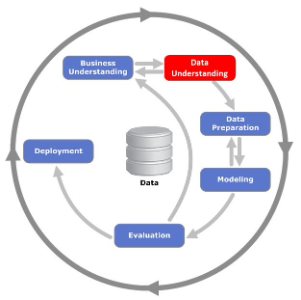

##Fonte de dados

Os dados podem ser acessados através o link: www.kaggle.com/datasets/henriqueyamahata/bank-marketing

##Dicionário de dados

**Variáveis explicativas:**

* Age: idade - numérica

* Job: tipo de emprego - categórica

* Marital : estado civil - categórico; obs: «divorciado» significa divorciado ou viúvo

* Education: escolaridade - categórica

* Default: tem crédito inadimplente? - categórica

* Housing: tem crédito habitação? - categórica

* Loan: tem empréstimo pessoal? - categórica

* Contact: tipo de comunicação de contato - categórica

* Month: último mês de contato do ano - categórica

* Day_of_week: último dia de contato da semana - categórica

* Compaign: quantidade de ligações foram feitas para o cliente nesta campanha - numérica

* Pdays: número de dias que se passaram após última ligação para o cliente em uma campanha anterior - numérica; 999 significa que o cliente não foi contatado anteriormente

* Previous: quantidade de ligações realizadas para o cliente antes desta campanha - numérica

* Poutcome: resultado da campanha de marketing anterior - categórica

* Emp.var.rate: taxa de variação do emprego - indicador trimestral - numérica

* Cons.price.idx: índice de preços no consumidor - indicador mensal - numérica

* Cons.conf.idx: índice de confiança do consumidor - indicador mensal - numérica

* Euribor3m: taxa euribor a 3 meses - indicador diário - numérica

* Nr.employed: número de empregados - indicador trimestral - numérica

* Duration: duração do último contato, em segundos - numérico; Observação importante: esse atributo afeta fortemente a target (por exemplo, se
duration=0 e y='no'). No entanto, a duração não é conhecida antes de uma chamada
ser realizada. Além disso, após o fim da chamada y é obviamente conhecido.
Assim, essa variável só deve ser incluída para fins de benchmark e
deve ser descartado se a intenção for ter um modelo preditivo realista.

<br>

**Target:**
* y: cliente subscreveu um depósito a prazo? - binário: 'sim', 'não'

<br>

>Observação: para conjunto de dados com uma grande quantidade de variáveis explicativas pode-se tornar inviável elaborar o dicionário de dados.

---

##Visualização dos dados

In [ ]:
# Importação dos dados
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projetos pessoais/01. Projetos Machine Learning/Propensão à compra de produto bancário/bank-additional-full.csv' , sep=';')

# Dropando a feature 'Duration', conforme orientação do dicionário de dados
data.drop('duration' , axis=1 , inplace=True)

# Gerando um ID aleatório para rasteio das observações
import uuid
data['ID'] = [str(uuid.uuid4())[:8] for _ in range(len(data))]

# Limitação do público
data = data[(data['age']>= 25) & (data['age']<= 65)]

# Criando cópia dos dados
abt_00=data.copy()

In [ ]:
# Visualizando linhas aleatórias
abt_00.sample(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
15237,27,blue-collar,married,basic.6y,no,yes,no,cellular,jul,thu,4,999,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1,no
21678,43,technician,married,high.school,no,yes,no,cellular,aug,tue,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,no
22600,57,technician,married,professional.course,unknown,yes,no,cellular,aug,fri,3,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,no


In [ ]:
# Criando os metadados
metadados_00 = report_data(abt_00)
metadados_00


  Quantidade de linhas duplicadas: 0  |  Quantidade de features com valores faltantes: 0
  Quantidade de features numéricas: 9  |  Quantidade de features categóricas 12
  Cardinalidade total das categóricas: 39556  |  Dataframe: 39501 linhas, 21 colunas
        


,Feature,Tipo,Card,%Miss,%Out_sup,%Out_inf,%Outliers,Moda,%Freq
0,age,int64,41,0.0,0.0,0.0,0.0,31.0,4.9
1,job,object,12,0.0,0.0,0.0,0.0,admin.,26.0
2,marital,object,4,0.0,0.0,0.0,0.0,married,61.7
3,education,object,8,0.0,0.0,0.0,0.0,university.degree,30.2
4,default,object,3,0.0,0.0,0.0,0.0,no,78.5
5,housing,object,3,0.0,0.0,0.0,0.0,yes,52.3
6,loan,object,3,0.0,0.0,0.0,0.0,no,82.4
7,contact,object,2,0.0,0.0,0.0,0.0,cellular,62.7
8,month,object,10,0.0,0.0,0.0,0.0,may,34.0
9,day_of_week,object,5,0.0,0.0,0.0,0.0,thu,20.9


Através do dataframe acima podemos extrair algumas informações que podem nos ajudar a entendendimento dos dados com foco no modelo:

* 5 variáveis explicativas não estão relacionadas aos indivíduos: 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx' e 'euribor3m'.

* A target (y) está em formato 'object' e suas saídas precisarão ser convertidas em valores binários.

* Ainda para a Target, existe um certo nível de desbalanceamento em sua distribuição: 89,6% dos indivíduos não subscreveram um empréstimo de longo prazo.

* Existem 1727 linhas duplicadas e que não serão removidas pois entende-se que cada linha (ou indivíduo) é de suma importância para o desempenho do modelo.

* Considerando todas as variáveis categoricas (11 features), e desconsiderando a target (2 categorias), teremos 55 - 11 - 2 = 42 novas colunas criadas no dataframe caso queiramos utilizar variáveis dummies para codificar estas features. Assim, o dataset final teria 42 + 9 = 51 variáveis explicativas. Dessa forma, não há nenhum problema causado pelo aumento da dimensionalidade, visto a grande quantidade de linhas no dataset (proporção de 53 colunas para 41188 linhas)


#Data Preparation


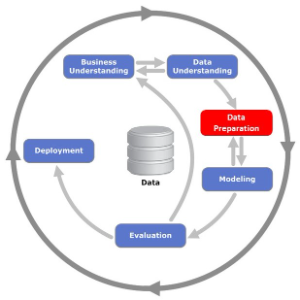

Na preparação dos dados, serão realizadas as seguintes etapas:


* Limitação do público entre 25 e 65 anos

* Codificação da target categórica para target binária

* Features com percentual de nulos acima de 70% serão removidas

* Features numéricas terão seus valores missing preenchidos com a **moda**

* Features categóricas terão seus valores missing preenchidos com a **moda**

* Codificação das variáveis categóricas, onde para as features com cardinalidade acima de 20 será aplicado o LabelEncoder e para cardinalidade menor ou igual a 20, o OneHotEncoder (criação de dummies)

<br>

Para automação do processo, grande parte da etapa de preparação dos dados será realizada através função que realiza as tarefas de codificação, imputação e dropagem de features. Além disso, esta função já aplica a validação cruzada Holdout, separando 30% dos dados para teste.

Após a preparação da conjunto de dados, será realizada uma rodada de Feature Selection, com o intuito de eliminar features que não agregam ao modelo. Nesta etapa outra função será responsável pelo processo.

<br>

Após a etapa de modelagem, será avaliada a necessidade de se retornar a esta etapa (DataPreparation)

In [ ]:
# Preparação dos dados - chamando a função
dataprep_01 = dataprep_out_of_sample(df=abt_00,
                                     target='y',
                                     col_id = 'ID',
                                     metadados=metadados_00,
                                     encoder_method = 'onehot+label',
                                     convert_target=True,
                                     scaled=False)

In [ ]:
# Resumo
print(dataprep_01.resume)

Resumo dataprep:

      • Limite de cardinalidade adotado: 20
      • Limite de percentual de nulos adotado: 70%
      • Quantidade de variáveis dropadas por nulos: 0
      • Quantidade de variáveis ao qual foi aplicado OneHotEncoder: 10
      • Quantidade de variáveis ao qual foi aplicado LabelEncoder: 0
      • Quantidade de variáveis ao qual foi aplicado StandardScaler: Não aplicado


In [ ]:
# Restaurando os dados de treino (redução do nome para facilidade)
X_train = dataprep_01.X_train_enc
y_train = dataprep_01.y_train

X_test = dataprep_01.X_test_enc
y_test = dataprep_01.y_test

In [ ]:
# Visualizando exemplo
X_train.head(3)

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_blue-collar_dummy,...,month_may_dummy,month_nov_dummy,month_oct_dummy,month_sep_dummy,day_of_week_mon_dummy,day_of_week_thu_dummy,day_of_week_tue_dummy,day_of_week_wed_dummy,poutcome_nonexistent_dummy,poutcome_success_dummy
15103,29,3,999,0,1.4,93.918,-42.7,4.958,5228.1,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
36430,33,1,999,1,-2.9,92.963,-40.8,1.262,5076.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4998,36,9,999,0,1.1,93.994,-36.4,4.858,5191.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [ ]:
# Lista de variáveis ao qual foi utilizado o OneHotEncoder
for i in dataprep_01.list_var_OneHotEncoder:
  print(f'- {i}')

- job
- marital
- education
- default
- housing
- loan
- contact
- month
- day_of_week
- poutcome


In [ ]:
# Lista de variáveis ao qual foi utilizado o scaler

if dataprep_01.list_var_scaled != 'Não aplicado':

  # printa a lista
  for i, value in enumerate(dataprep_01.list_var_scaled, start=1):
      print(f'- {value:<35}', end='')  # Ajuste o número para o espaçamento desejado

      # Verifica se já foram impressos 3 elementos (três colunas)
      if i % 3 == 0:
          # Se sim, pula para a próxima linha
          print()

In [ ]:
# Verificando as volumetrias
print(f'Dataframe original: {abt_00.shape}')
print(f'X de treino:        {X_train.shape}')
print(f'X de teste:         {X_test.shape}')
print(f'Y de treino:        {y_train.shape}')
print(f'Y de teste:         {y_test.shape}')

Dataframe original: (39501, 21)
X de treino:        (27650, 52)
X de teste:         (11851, 52)
Y de treino:        (27650,)
Y de teste:         (11851,)


##Feature selection

A etapa de Feature Selection será realizada com o intuito de reduzir o número de variáveis do modelo. Isto traz benefícios como a redução de dados ruidosos e sem importância nas predições e ganho de performance computacional no processamento. Nesta etapa, iniciaremos fazendo um corte na importância das features igual a 40% da maior importância encontrada.


Features removidas: 49
Features remanescentes: 3



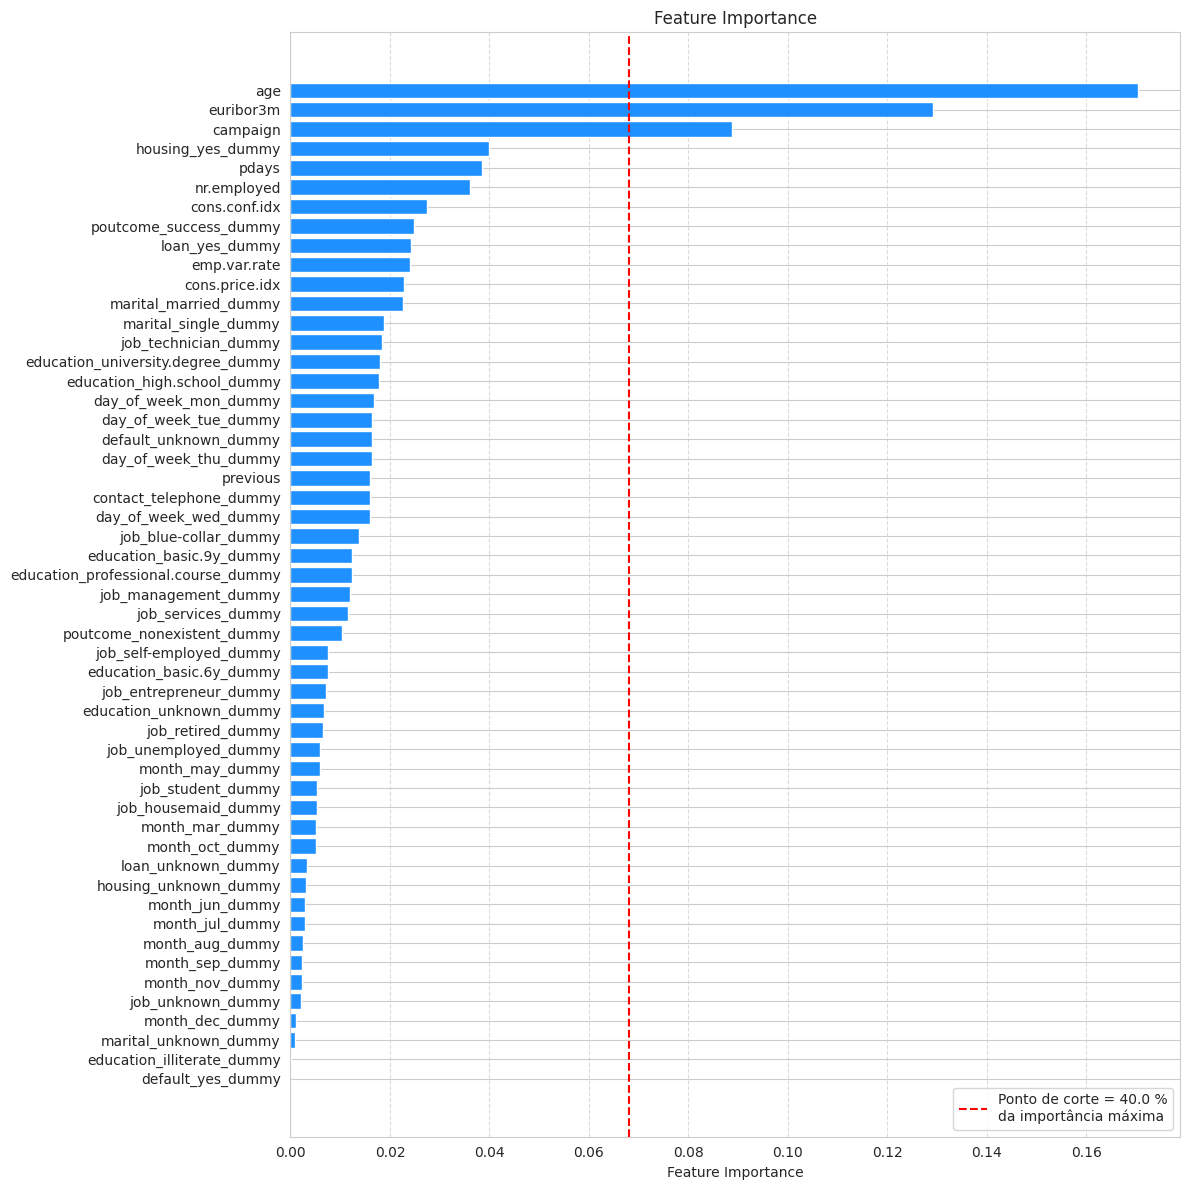

In [ ]:
# Calculando e visualizando a Feature Importance

# Instanciando o modelo
model = RandomForestClassifier(random_state=42)



# Chamando a função
lista_fs_importance = fs_importance(model=model,
                                    X=X_train ,
                                    y=y_train ,
                                    cutoff_importance = 0.4,
                                    plot=True ,
                                    figsize=(12,12))

In [ ]:
# Lista de features seleciondas - sem variáveis dummy

# Removendo sufixo "_dummy" e mantendo apenas a parte anterior à penúltima '_'
lista = [item.rsplit('_', 2)[0] if item.endswith('_dummy') else item for item in lista_fs_importance]

# Convertendo para conjunto para remover duplicatas e convertendo novamente para lista
lista = list(set(lista))

# Exibindo a lista sem duplicatas
lista

['euribor3m', 'campaign', 'age']

Com o ponto de corte igual a 40% da maior importância, somente 3 features foram selecionadas, o que não é interessante do ponto de vista da modelagem pois os resultados ficam extremamente dependentes de poucas variáveis. Quaisquer variações bruscas em seus valores poderiam acarretar em perda do poder preditivo do modelo.

<br>

Sendo assim, mesmo com as demais features possuindo baixa importância, o ponto de corte será reduzido para que um número maior de features seja incluido no modelo.

<br>

O novo ponto de corte será de 10%.


Features removidas: 36
Features remanescentes: 16



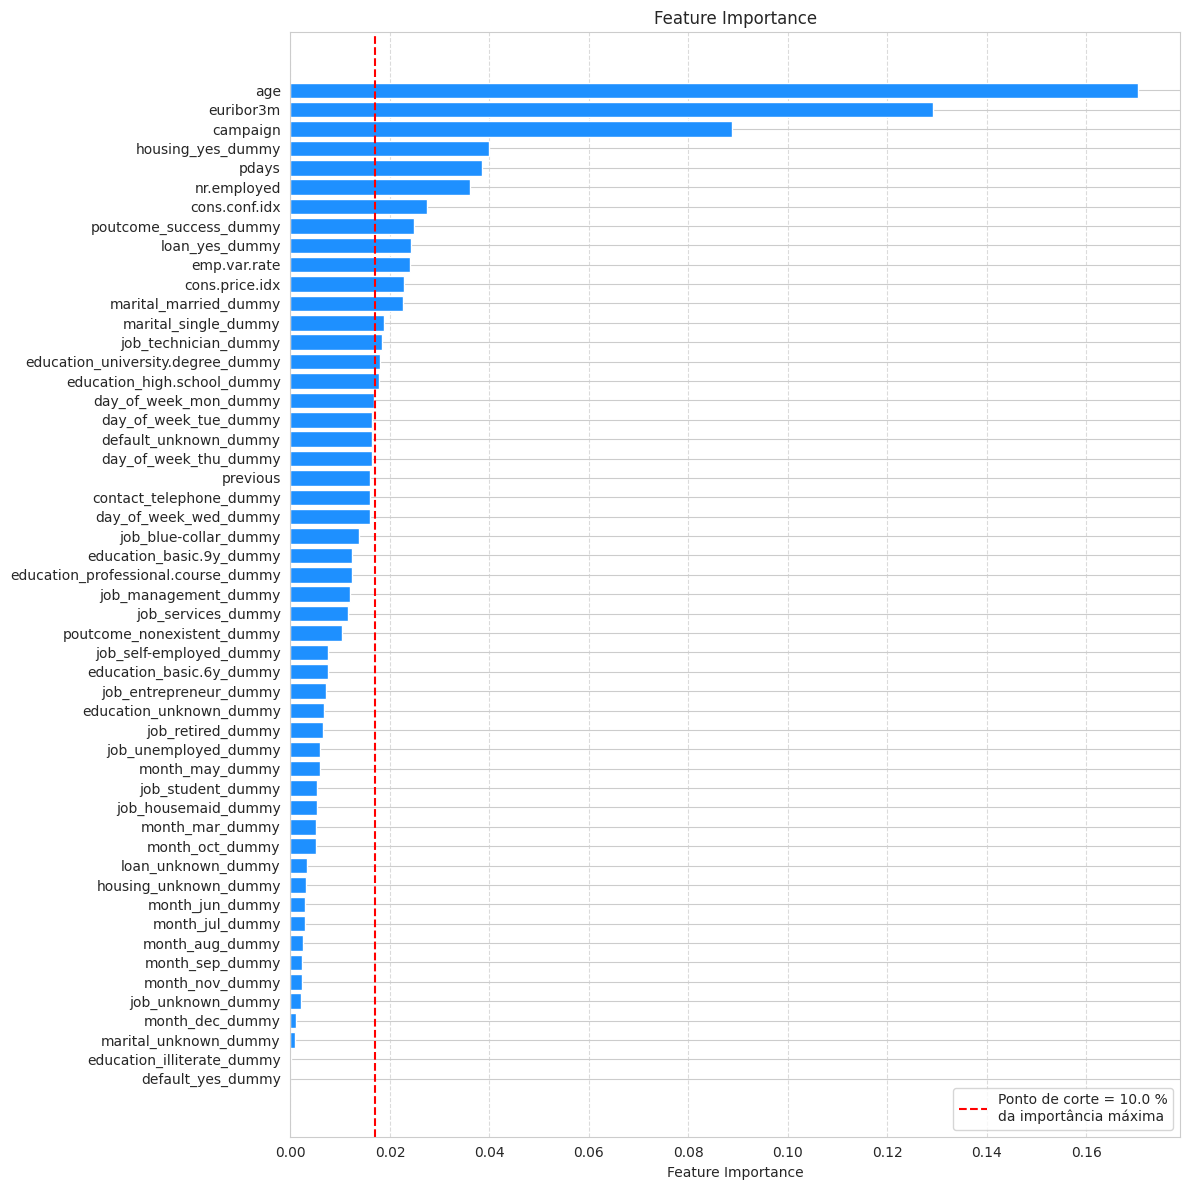

In [ ]:
# Calculando e visualizando a Feature Importance

# Instanciando o modelo
model = RandomForestClassifier(random_state=42)



# Chamando a função
lista_fs_importance = fs_importance(model=model,
                                    X=X_train ,
                                    y=y_train ,
                                    cutoff_importance = 0.1,
                                    plot=True ,
                                    figsize=(12,12))

In [ ]:
# Lista de features seleciondas - sem variáveis dummy

# Removendo sufixo "_dummy" e mantendo apenas a parte anterior à penúltima '_'
lista = [item.rsplit('_', 2)[0] if item.endswith('_dummy') else item for item in lista_fs_importance]

# Convertendo para conjunto para remover duplicatas e convertendo novamente para lista
lista = list(set(lista))

# Exibindo a lista sem duplicatas
lista

['euribor3m',
 'job',
 'poutcome',
 'pdays',
 'loan',
 'cons.price.idx',
 'age',
 'cons.conf.idx',
 'education',
 'housing',
 'campaign',
 'nr.employed',
 'emp.var.rate',
 'marital']

Agora, 14 features foram selecionadas para o modelo, sendo algumas delas categóricas e, na fase de preparação para novas predições, deverão ser convertidas em features numéricas ou em variáveis dummy.

In [ ]:
# Ajustando a tabela analítica de modelagem com as features selecionadas

# Restaurando somente as features selecionadas e o target
abt_02 = abt_00[lista + ['ID','y']].copy()

In [ ]:
# Gerando novo report
metadados_02 = report_data(abt_02)
metadados_02


  Quantidade de linhas duplicadas: 0  |  Quantidade de features com valores faltantes: 0
  Quantidade de features numéricas: 8  |  Quantidade de features categóricas 8
  Cardinalidade total das categóricas: 39536  |  Dataframe: 39501 linhas, 16 colunas
        


,Feature,Tipo,Card,%Miss,%Out_sup,%Out_inf,%Outliers,Moda,%Freq
0,euribor3m,float64,315,0.0,0.0,0.0,0.0,4.857,7.2
1,job,object,12,0.0,0.0,0.0,0.0,admin.,26.0
2,poutcome,object,3,0.0,0.0,0.0,0.0,nonexistent,87.1
3,pdays,int64,26,0.0,0.0,3.2,3.2,999.0,96.8
4,loan,object,3,0.0,0.0,0.0,0.0,no,82.4
5,cons.price.idx,float64,26,0.0,0.0,0.0,0.0,93.994,19.5
6,age,int64,41,0.0,0.0,0.0,0.0,31.0,4.9
7,cons.conf.idx,float64,26,0.0,0.9,0.0,0.9,-36.4,19.5
8,education,object,8,0.0,0.0,0.0,0.0,university.degree,30.2
9,housing,object,3,0.0,0.0,0.0,0.0,yes,52.3


In [ ]:
# Gerando novo dataprep
dataprep_03 = dataprep_out_of_sample( df=abt_02,
                                      target='y',
                                      col_id='ID',
                                      metadados=metadados_02,
                                      scaled=False ,
                                      encoder_method = 'onehot+label',
                                      convert_target=True)

# Restaurando os dados de treino e teste
# Redução do nome para facilidade
X_train = dataprep_03.X_train_enc
X_test = dataprep_03.X_test_enc
y_train = dataprep_03.y_train
y_test = dataprep_03.y_test

# Restaurando os ID's
id_train = dataprep_03.col_id_train
id_test = dataprep_03.col_id_test

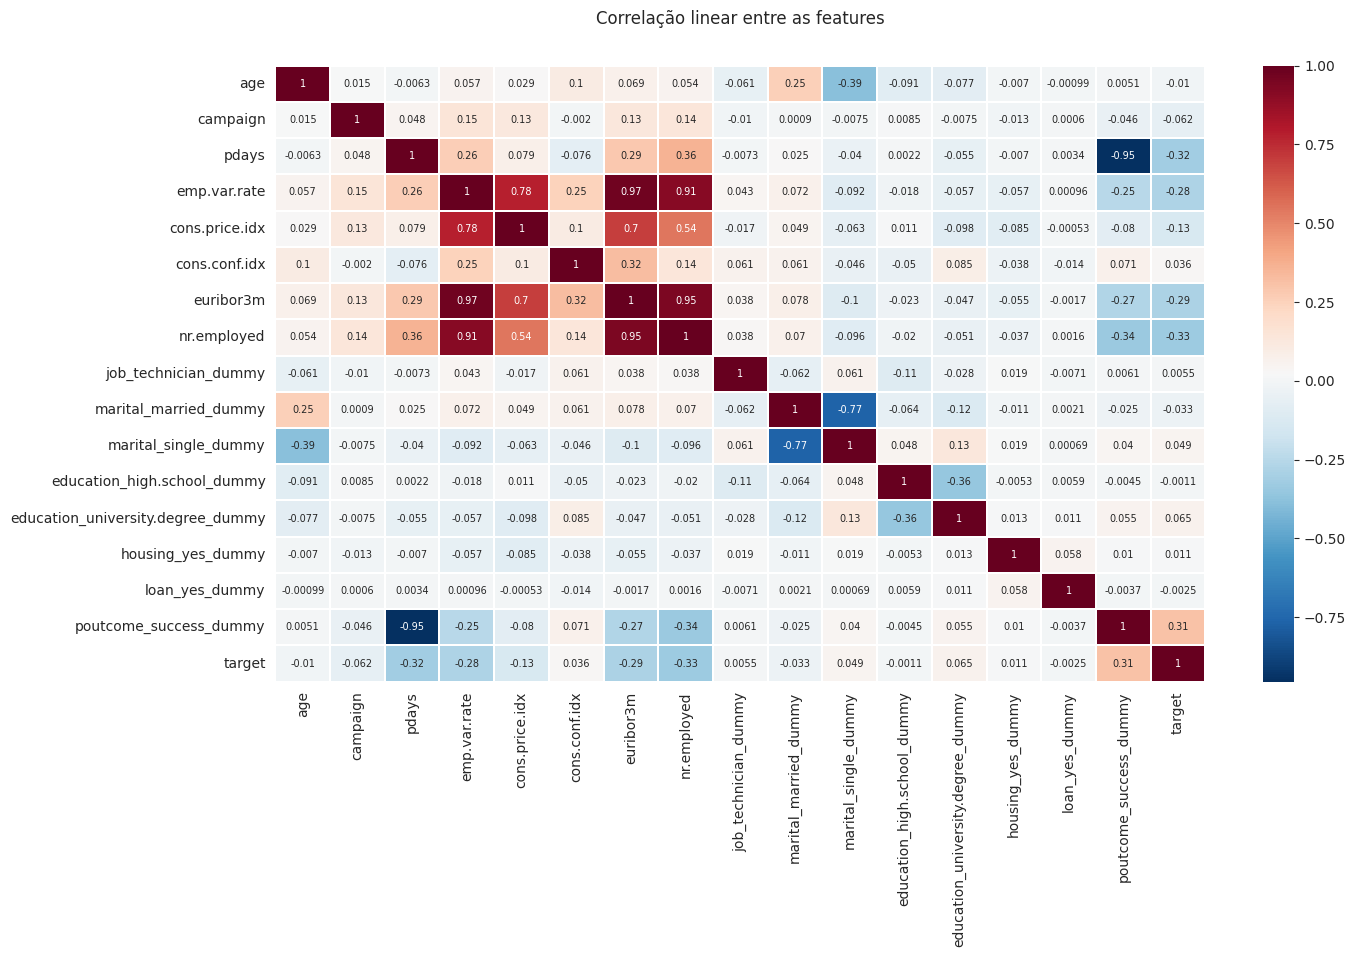

In [ ]:
# Verificando a correlação entre as variáveis selecionadas
# Observação: verificando somente as dummies que passaram
# pela etapa de Feature Selection

df_aux = X_train[lista_fs_importance].copy()
df_aux['target'] = y_train

fig, ax = plt.subplots(figsize=(15,8))

sns.heatmap(df_aux.corr(), annot=True, linewidth=0.2, cmap='RdBu_r' , annot_kws = {'size': 7} )
plt.title('Correlação linear entre as features' , pad=30)
_=plt.show()

Através do Heatmap de correlação observa-se que algumas features estão altamente correlacionadas entre si. Isso pode ter ocorrido em função da redução do ponto de corte da Feature Importance, o que fez com que algumas variáveis que carregam informações de outras passassem pelo filtro.

De acordo com o heatmap, as variáveis com alta correlação linear entre si são:

- 'euribor3m'  x  'emp.var.rate'  x  'nr.employed'
- 'pdays'  x  'poutcome_success_dummy'

Serão removidas manualmente as variáveis com menor poder preditivo dentre as combinações acima.

In [ ]:
# Removendo da lista de features originais selecionadas
lista.remove('emp.var.rate')
lista.remove('nr.employed')
# lista.remove('poutcome')

lista_fs_importance.remove('emp.var.rate')
lista_fs_importance.remove('nr.employed')
lista_fs_importance.remove('poutcome_success_dummy')


# Restaurando somente as features selecionadas e o target
abt_03 = abt_00[lista + ['y','ID']].copy()


# Metadados
metadados_03 = report_data(abt_03)


# Aplicando novo dataprep (para atualizar a lista dos encoders)
dataprep_04 = dataprep_out_of_sample( df=abt_03,
                                      target='y',
                                      col_id='ID',
                                      metadados=metadados_03,
                                      scaled=False ,
                                      encoder_method = 'onehot+label',
                                      convert_target=True)


# Restaurando os dados de treino e teste
# Redução do nome para facilidade
X_train = dataprep_04.X_train_enc[lista_fs_importance]
X_test = dataprep_04.X_test_enc[lista_fs_importance]
y_train = dataprep_04.y_train
y_test = dataprep_04.y_test

# Restaurando os ID's
id_train = dataprep_04.col_id_train
id_test = dataprep_04.col_id_test


  Quantidade de linhas duplicadas: 0  |  Quantidade de features com valores faltantes: 0
  Quantidade de features numéricas: 6  |  Quantidade de features categóricas 8
  Cardinalidade total das categóricas: 39536  |  Dataframe: 39501 linhas, 14 colunas
        


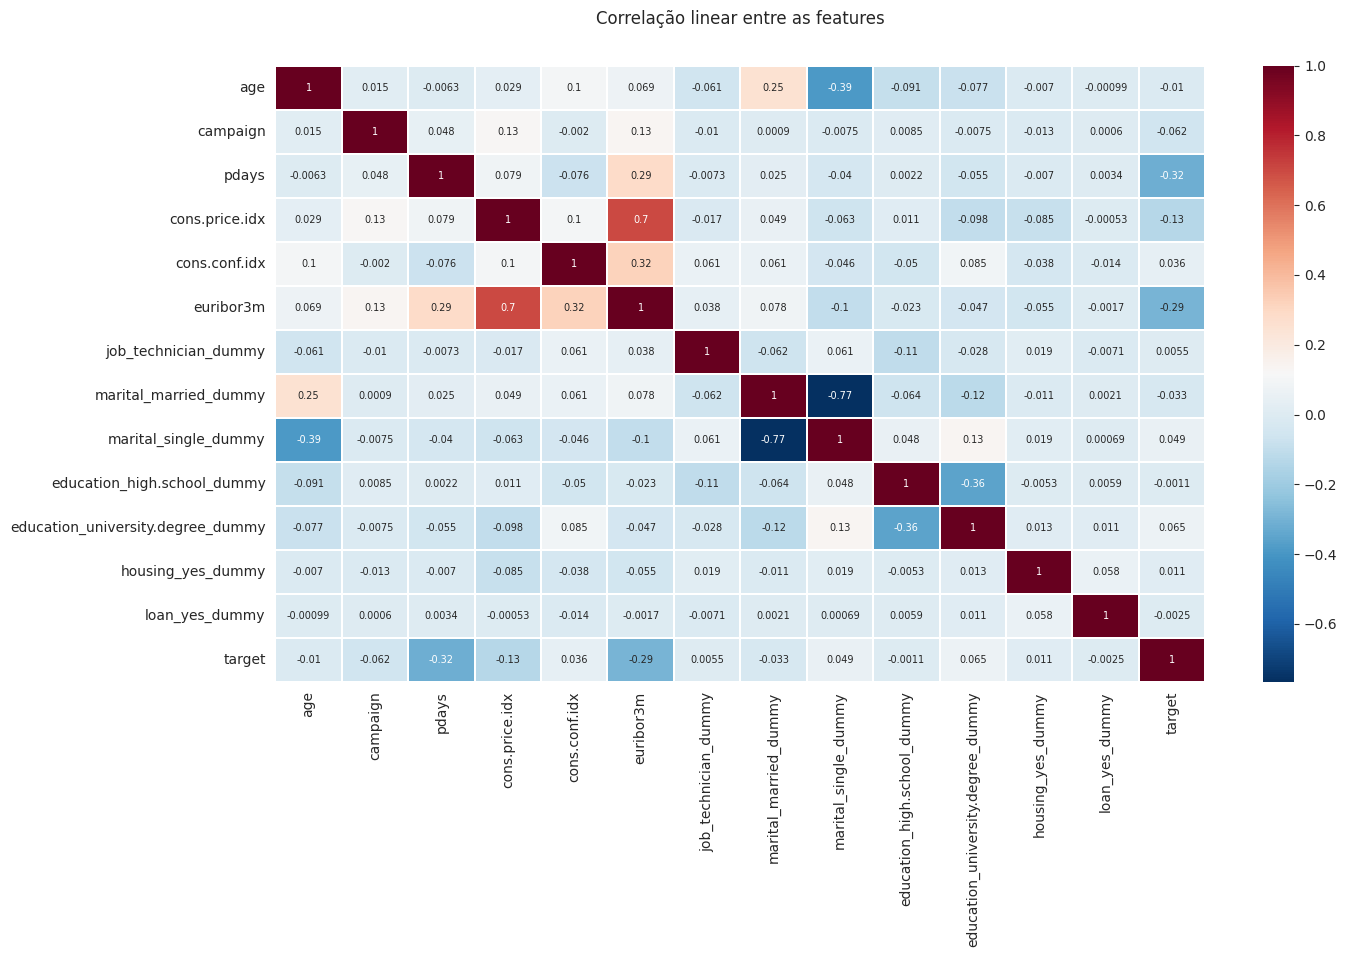

In [ ]:
# Verificando a correlação entre as variáveis selecionadas
df_aux = X_train.copy()
df_aux['target'] = y_train

fig, ax = plt.subplots(figsize=(15,8))

sns.heatmap(df_aux.corr(), annot=True, linewidth=0.2, cmap='RdBu_r' , annot_kws = {'size': 7} )
plt.title('Correlação linear entre as features' , pad=30)
_=plt.show()

Dessa forma, chegou-se a lista final de features para uma primeira etapa de modelagem.

<br><br>

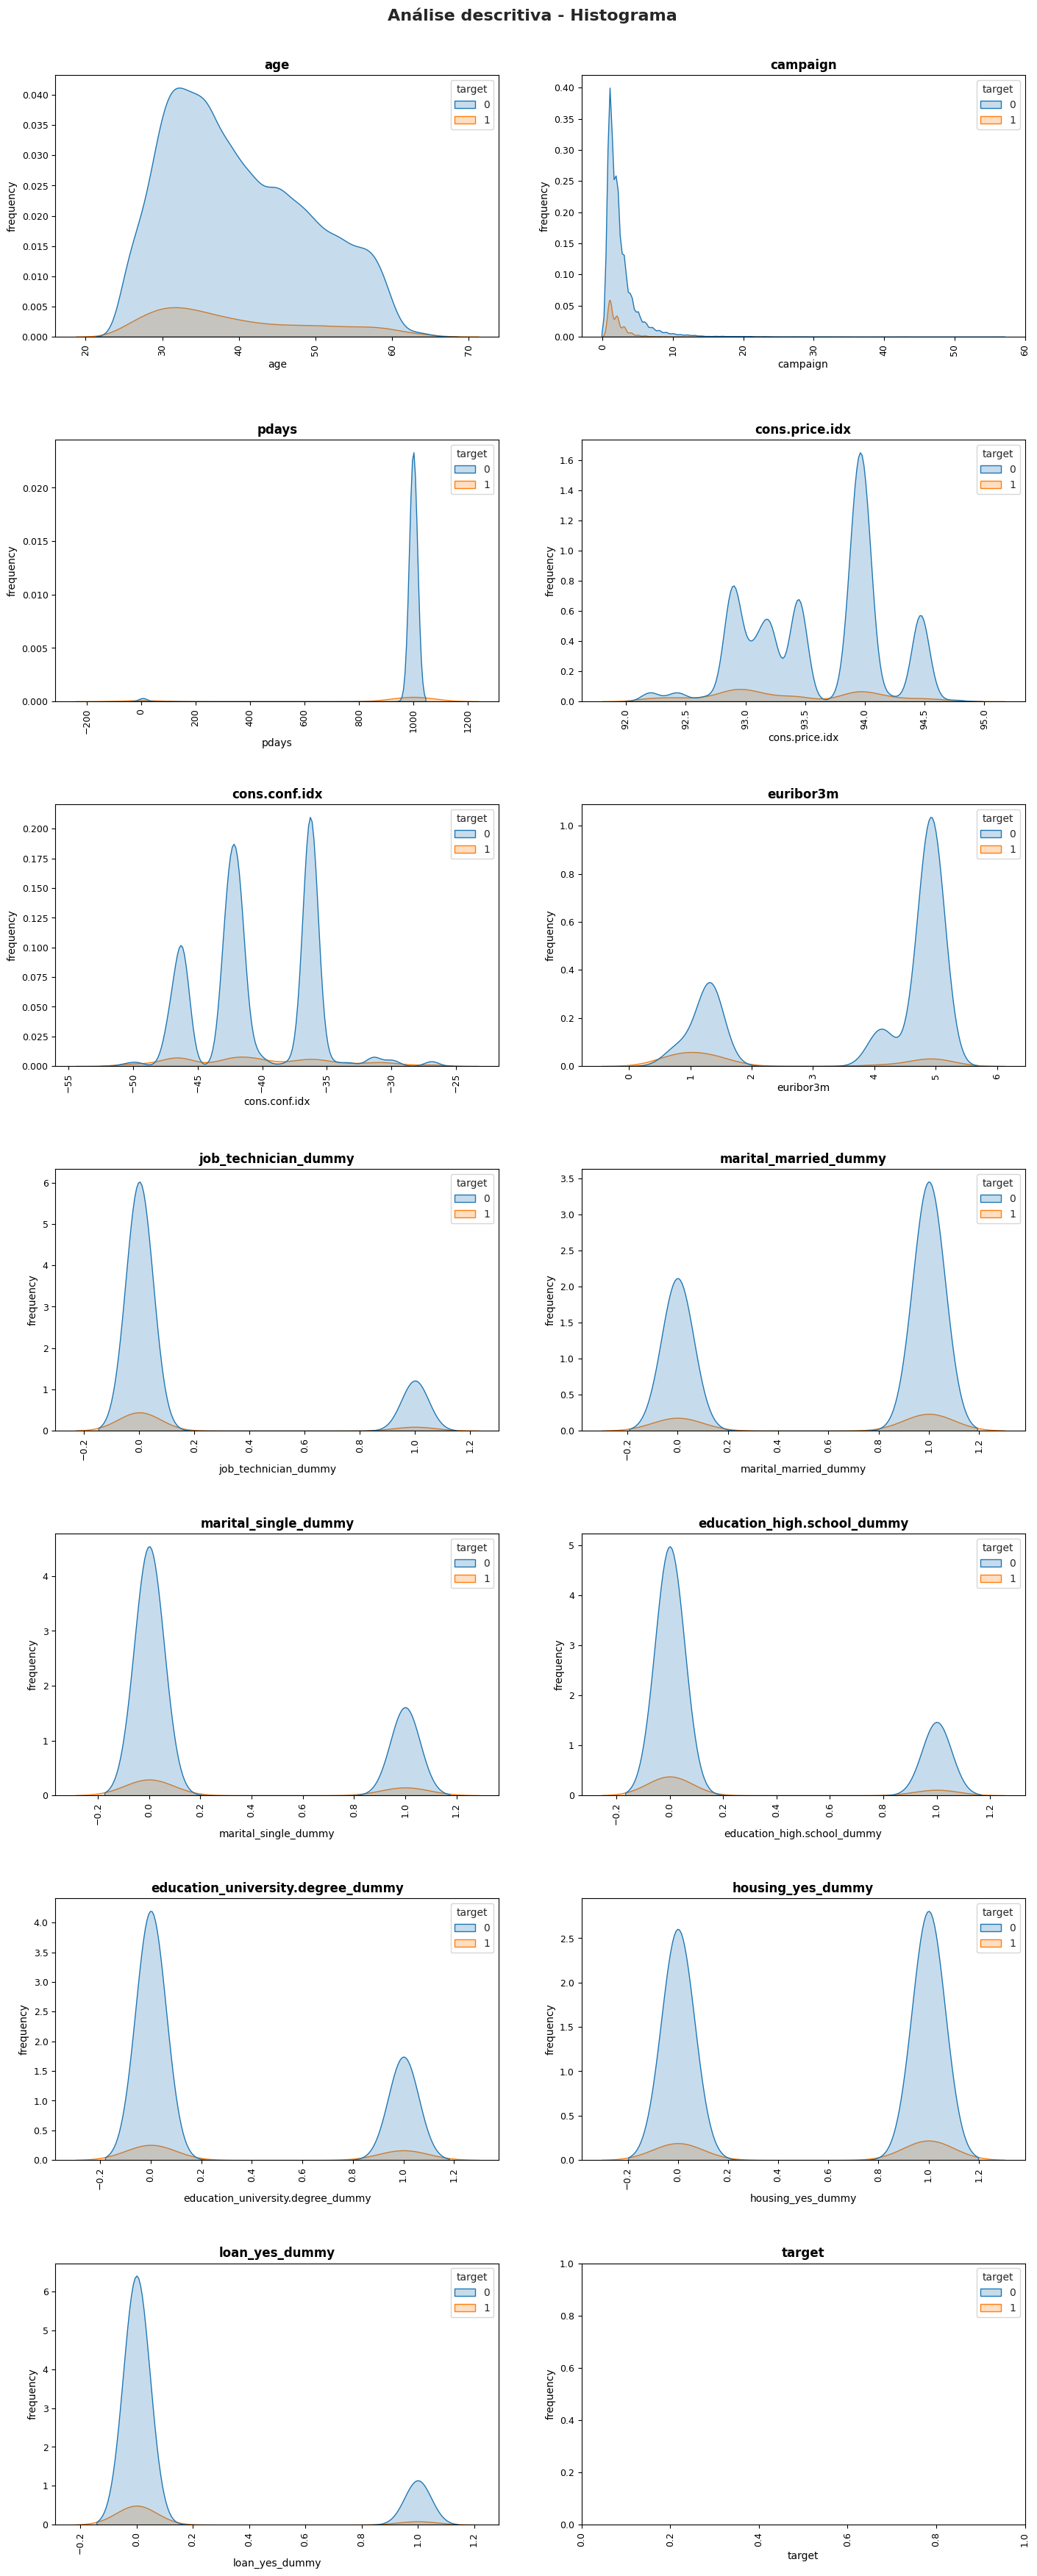

In [ ]:
# Visualizando a dstribuição das features numéricas selecionadas em relação à target
plot_batch_histogram(df_aux, cols=2, hue='target')

Conforme os gráficos acima, é possível visualizar que todas as variáveis numpericas são capazes de segregar "evento" de "não-evento".

#Modeling

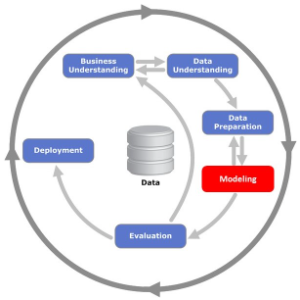

Como base nas informações do 'Business Understanding' optaremos por utilizar um modelo de Floresta Aleatória (RandomForest).

Esta escolha se baseia no seguinte:

* É um modelo que traz certa explicabilidade, atendendo à necessidade do negócio em saber os fatores que mais influenciam a propensão de adesão aos serviços ou não por parte dos clientes

* É um modelo com boa capacidade de predição, se tratando de um ensemble do tipo bagging

* É um modelo de baixo custo computacional, o que favorece a sua implantação online, tornando o processo rápido para o usuário final ao ser feita a chamada da API

* Sendo um modelo de baixo custo computacional, garante-se o menor impacto possível na infraestrutura existente.

##Modelo baseline

In [ ]:
# Intanciando o modelo RandomForest
rf = RandomForestClassifier(random_state=42)

# Treinando o modelo
rf.fit(X_train, y_train)

# Previsões nos dados de treino
y_train_pred = rf.predict(X_train)
y_train_pred_prob = rf.predict_proba(X_train)

# Previsões nos dados de teste
y_pred = rf.predict(X_test)
y_pred_prob = rf.predict_proba(X_test)

In [ ]:
# Tabela de métricas - RandomForest
df_metrics_rf = calculate_metrics('RandomForest - baseline', rf, X_train, y_train, X_test, y_test)

# Exibindo
df_metrics_rf

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,RandomForest - baseline,Treino,0.986438,0.987140,0.881043,0.998651,0.997301,0.969176
1,RandomForest - baseline,Teste,0.889292,0.434229,0.251846,0.739982,0.479963,0.404684


Analisando a tabela de resultados das métricas acima, percebe-se claramente a ocorrência de overfiting. A alta performance do modelo ao predizer os dados de treino indicam que o modelo encontrou padrões até mesmo nos ruídos destes dados, e não é capaz de generalizar as predições para os dados de teste.

##Modelo tunado

In [ ]:
# Instanciando
rf = RandomForestClassifier(random_state=42)

# Criando o grid de hiperparâmetros
grid_param = {
      'criterion': ['gini','entropy'],
      'n_estimators': [100,300],                 # Quantidade de estimadores (árvores)
      'max_depth': [3],                          # Profundidade máxima da árvore
      'min_samples_split': [1,5,10],             # Número mínimo de amostras necessárias para dividir um nó interno.
      'min_samples_leaf': [1,5,10],              # Número mínimo de amostras necessárias para estar em um nó folha.
      'class_weight': [{0: 1, 1: 1} ,            # Balanceamento das classes
                       {0: 1, 1: 4} ,
                       {0: 1, 1: 8} ,
                       {0: 1, 1: 12}] }

# Chamando o GridSearch
grid = GridSearchCV(rf, grid_param, cv=5, scoring='recall', n_jobs=-1)  # 'accuracy' 'precision' 'recall' 'f1'

# Treinando o modelo com GridSearch
grid.fit(X_train, y_train)

# Obtendo o melhor modelo
rf_opt = grid.best_estimator_

In [ ]:
# Melhor recall encontrado
print(f'recall = {grid.best_score_}')

recall = 0.6848695652173913


In [ ]:
# Visualizando os melhores hiperparâmetros
grid.best_params_

{'class_weight': {0: 1, 1: 12},
 'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 100}

In [ ]:
# Calculando e visualizando as métricas
df_metrics_rf_opt = calculate_metrics('RandomForest tunado', rf_opt, X_train, y_train, X_test, y_test)
df_metrics_rf_opt

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,RandomForest tunado,Treino,0.726546,0.228316,0.68487,0.777621,0.555242,0.461757
1,RandomForest tunado,Teste,0.729137,0.224924,0.66776,0.772914,0.545828,0.447051


Agora, as métricas obtidas com as predições nos dados de treino estão muito próximas das predições nos dados de teste.
<br><br>

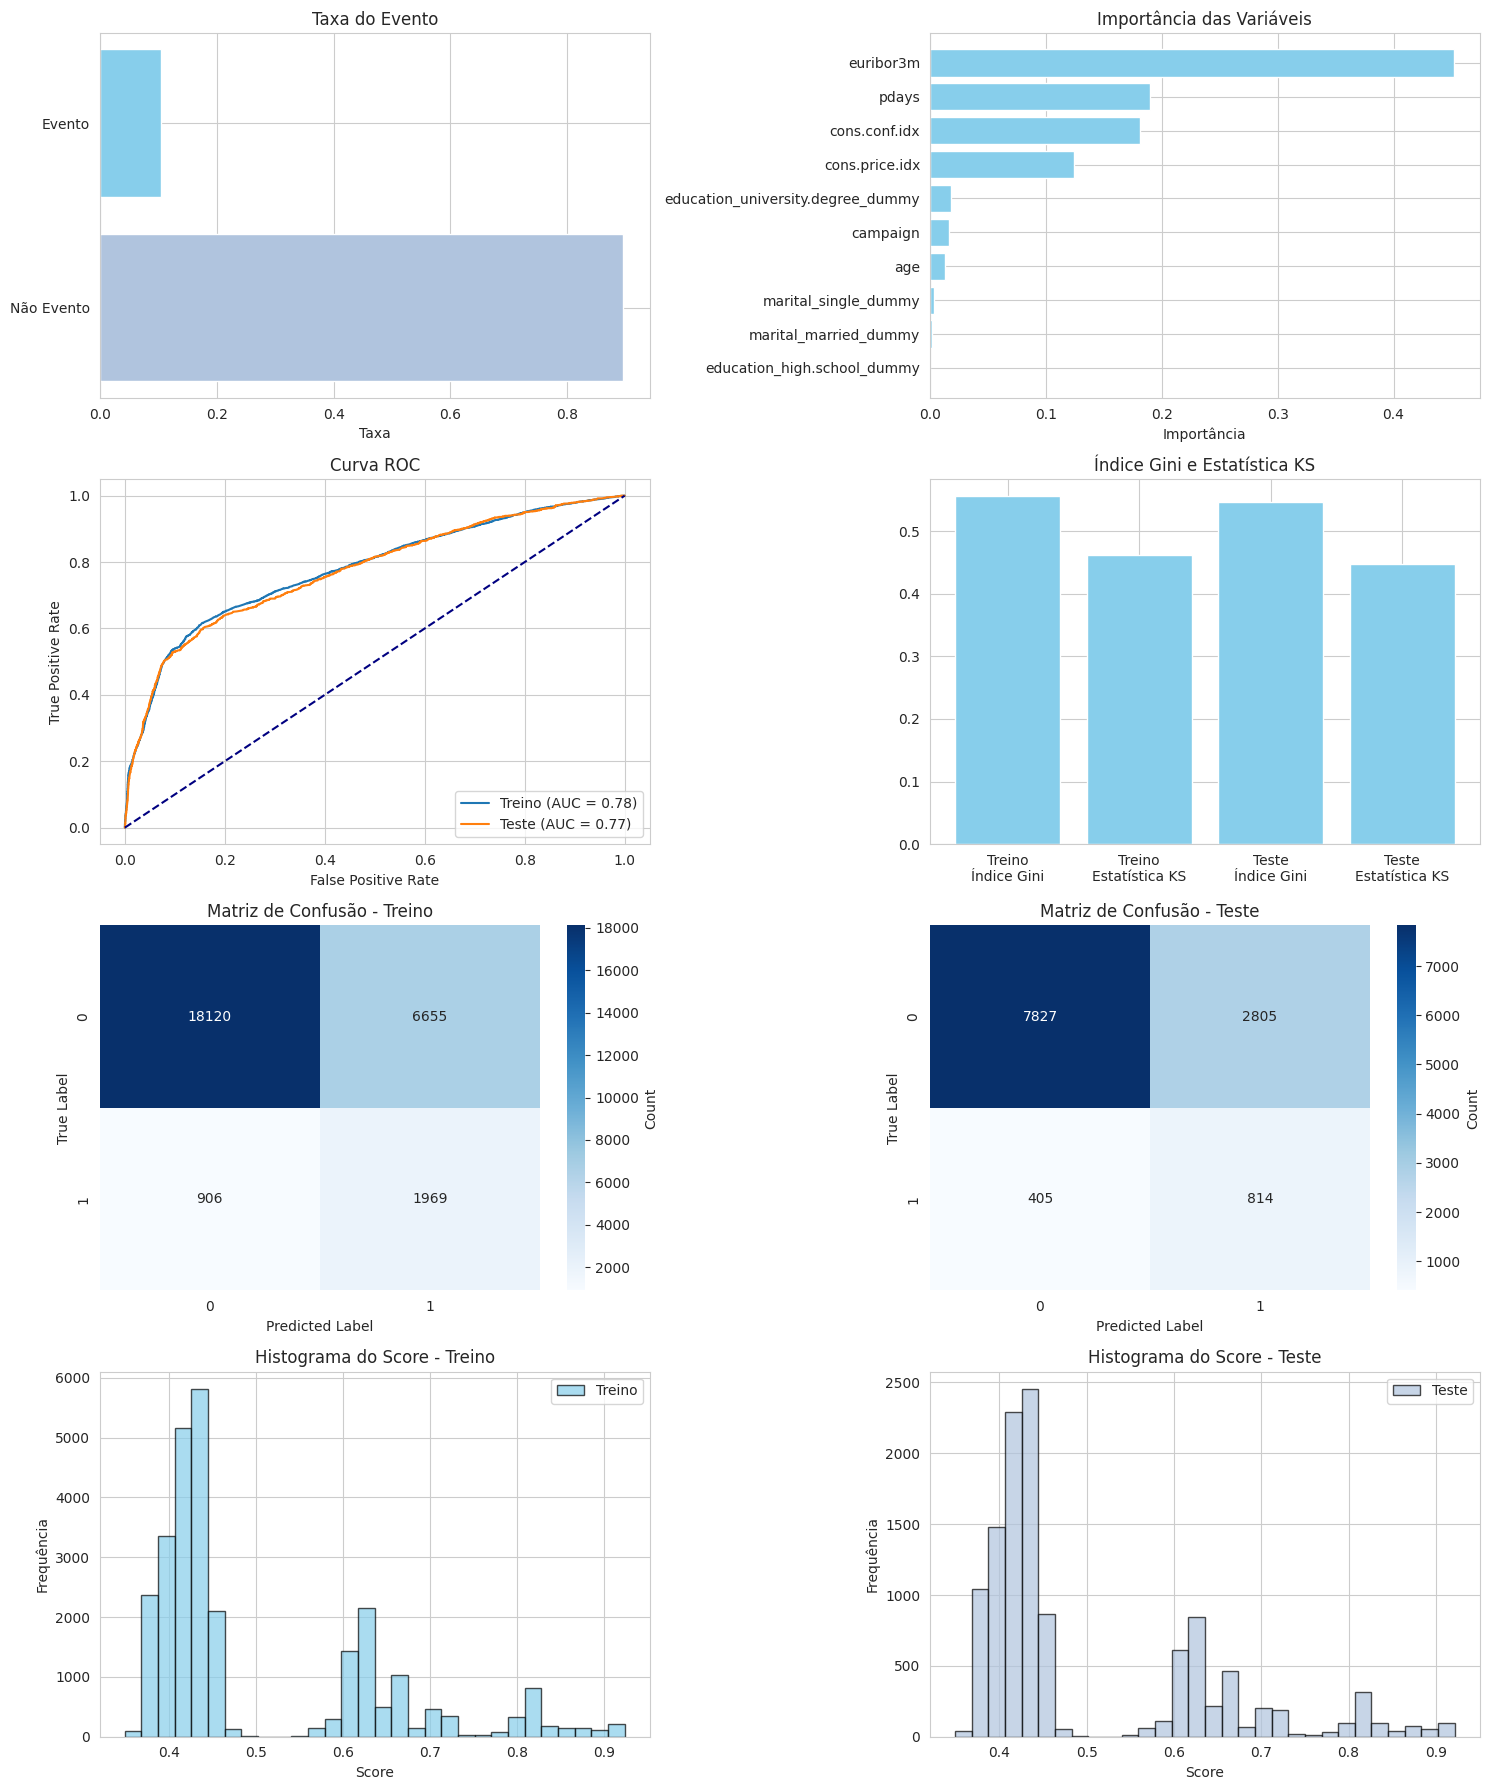

In [ ]:
# Visualizando as métricas
plot_metrics(rf_opt, X_train, y_train, X_test, y_test)

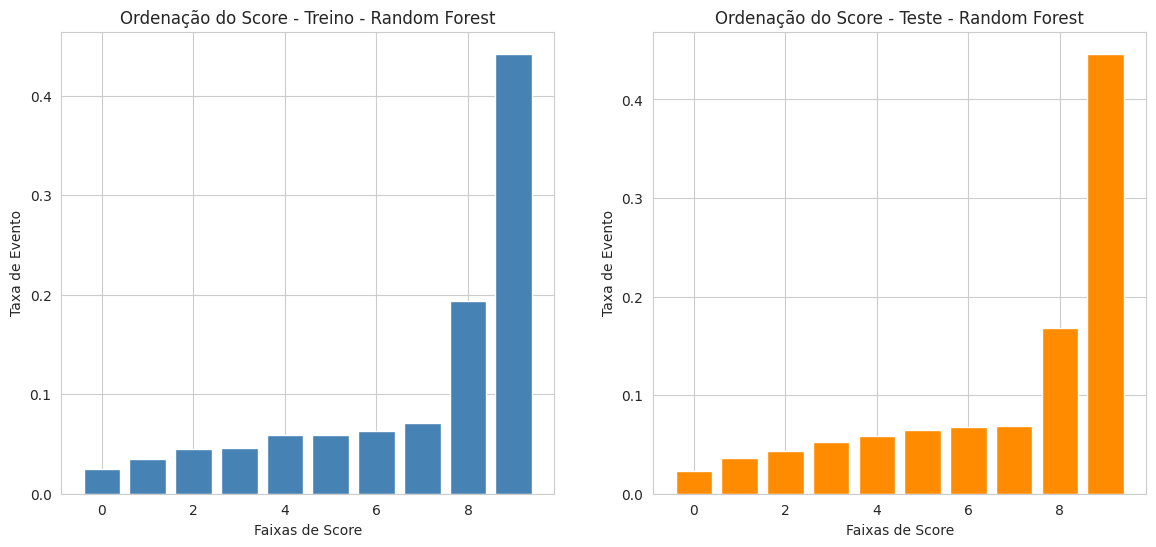

In [ ]:
# Ordenação dos scores
ordena_score(rf_opt, 'Random Forest', X_train, X_test, y_train, y_test , n_bins=10)

#Evaluation

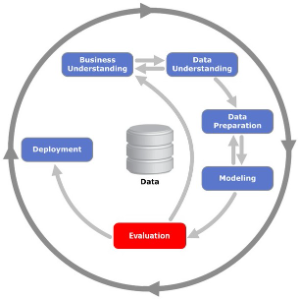

Nesta etapa será feita a avaliação do modelo junto com o time de negócios. Caso o modelo seja validado, serão extraídos os artefatos utilizados para que seja realizado o deploy. Caso haja alguma inconsistência seja identificada, reavaliaremos as etapas anteriores (Business Understanding, Data Understanding, Data Preparation e Modeling) com o intuito de tornar o modelo mais alinhado com o negócio.

<br>

**Taxa de evento:**

  Mantém a proporção do conjunto de dados inicial, que é de aproximadamente 10.4% de evento (saída de target igual a 1 - propensão à compra)

<br>

**Importância das variáveis:**

Analisando as 5 features com maior relevância após o treinamento do modelo:
- 'euribor3m' : indicador econômico e feature de maior relevância
- 'pdays': número de dias que se passaram após última ligação para o cliente em uma campanha anterior; 999 significa que o cliente não foi contatado anteriormente. Para clientes que receberam contato em campanhas de dois anos atrás (aproximadamente 720 dias), esta feature pode começar a comprometer o desempenho das predições pois o valor real dos dias se aproximará do valor que representa o "não-contato" (999).
- 'cons.conf.idx': indicador econômico
- 'cons.price.idx': indicador econômico
- 'poutcome_nonexistent_dummy': variável dummy originada de 'poutcome'. Representa o resultado da campanha de marketing anterior


<br>

**Métricas do modelo nos dados de teste**:
Os valores da métrica de avaliação principal do modelo é:
* Recall: 0.68

Um recall de 0.68 (ou 68%) significa que o modelo é capaz de identificar corretamente 68% das instâncias positivas em relação ao total de instâncias positivas no conjunto de dados. Isso indica uma performance razoável na capacidade do modelo de capturar casos positivos, e está satisfatório do ponto de vista do negócio.


<br>


**Ordenação do score**:

Os scores não possuem ordenação visível. Porém, do ponto de vista do negócio, será priorizada a avaliação da métrica recall.


<br>

**Ajustes necessários**

Para reduzir a influência de indicadores ecõnimos nas decisoes do modelo, a equipe de negócio optou em não utilizar as variáveis:
- 'cons.conf.idx'
- 'conf.price.idx'

A feature 'euribor3m' foi mantida por possuir boa capacidade preditora.

#Data Preparation


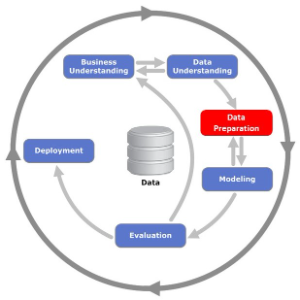

Retornando a esta etapa para remoção das features:
- 'cons.conf.idx'
- 'cons.price.idx'



In [ ]:
# Removendo da lista de features originais selecionadas
lista.remove('cons.conf.idx')
lista.remove('cons.price.idx')

lista_fs_importance.remove('cons.conf.idx')
lista_fs_importance.remove('cons.price.idx')


# Restaurando somente as features selecionadas e o target
abt_04 = abt_00[lista + ['y', 'ID']].copy()

# Metadados
metadados_04 = report_data(abt_04)


# Aplicando novo dataprep (para atualizar a lista dos encoders)
dataprep_05 = dataprep_out_of_sample( df=abt_04,
                                      target='y',
                                      col_id='ID',
                                      metadados=metadados_04,
                                      scaled=False ,
                                      encoder_method = 'onehot+label',
                                      convert_target=True)


# Restaurando os dados de treino e teste
# Redução do nome para facilidade
X_train = dataprep_05.X_train_enc[lista_fs_importance]
X_test = dataprep_05.X_test_enc[lista_fs_importance]
y_train = dataprep_05.y_train
y_test = dataprep_05.y_test


# Restaurando os ID's
id_train = dataprep_05.col_id_train
id_test = dataprep_05.col_id_test


# Restaurando somente as features selecionadas e o target
abt_05 = abt_00[lista + ['y', 'ID']].copy()


# criando os matadados
metadados_05 = report_data(abt_05)
metadados_05


  Quantidade de linhas duplicadas: 0  |  Quantidade de features com valores faltantes: 0
  Quantidade de features numéricas: 4  |  Quantidade de features categóricas 8
  Cardinalidade total das categóricas: 39536  |  Dataframe: 39501 linhas, 12 colunas
        

  Quantidade de linhas duplicadas: 2957  |  Quantidade de features com valores faltantes: 0
  Quantidade de features numéricas: 4  |  Quantidade de features categóricas 7
  Cardinalidade total das categóricas: 35  |  Dataframe: 39501 linhas, 11 colunas
        


,Feature,Tipo,Card,%Miss,%Out_sup,%Out_inf,%Outliers,Moda,%Freq
0,euribor3m,float64,315,0.0,0.0,0.0,0.0,4.857,7.2
1,job,object,12,0.0,0.0,0.0,0.0,admin.,26.0
2,poutcome,object,3,0.0,0.0,0.0,0.0,nonexistent,87.1
3,pdays,int64,26,0.0,0.0,3.2,3.2,999.0,96.8
4,loan,object,3,0.0,0.0,0.0,0.0,no,82.4
5,age,int64,41,0.0,0.0,0.0,0.0,31.0,4.9
6,education,object,8,0.0,0.0,0.0,0.0,university.degree,30.2
7,housing,object,3,0.0,0.0,0.0,0.0,yes,52.3
8,campaign,int64,42,0.0,5.9,0.0,5.9,1.0,42.5
9,marital,object,4,0.0,0.0,0.0,0.0,married,61.7


#Modeling

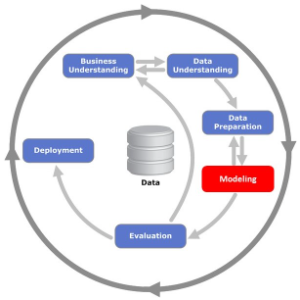

##Modelo tunado

In [ ]:
# Instanciando
rf = RandomForestClassifier(random_state=42)

# Criando o grid de hiperparâmetros
grid_param = {
      'criterion': ['gini','entropy'],
      'n_estimators': [100,300],                 # Quantidade de estimadores (árvores)
      'max_depth': [3],                          # Profundidade máxima da árvore
      'min_samples_split': [1,5,10],             # Número mínimo de amostras necessárias para dividir um nó interno.
      'min_samples_leaf': [1,5,10],              # Número mínimo de amostras necessárias para estar em um nó folha.
      'class_weight': [{0: 1, 1: 1} ,            # Balanceamento das classes
                       {0: 1, 1: 4} ,
                       {0: 1, 1: 8} ,
                       {0: 1, 1: 12}] }

# Chamando o GridSearch
grid = GridSearchCV(rf, grid_param, cv=5, scoring='recall', n_jobs=-1)  # 'accuracy' 'precision' 'recall' 'f1'

# Treinando o modelo com GridSearch
grid.fit(X_train, y_train)

# Obtendo o melhor modelo
rf_opt = grid.best_estimator_

In [ ]:
# Melhor score encontrado
print(f'recall = {grid.best_score_}')

recall = 0.6869565217391305


In [ ]:
# Visualizando os melhores hiperparâmetros
grid.best_params_

{'class_weight': {0: 1, 1: 12},
 'criterion': 'entropy',
 'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 300}

In [ ]:
# Calculando e visualizando as métricas
df_metrics_rf_opt = calculate_metrics('RandomForest tunado', rf_opt, X_train, y_train, X_test, y_test)
df_metrics_rf_opt

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,RandomForest tunado,Treino,0.725678,0.227809,0.685565,0.766558,0.533116,0.448226
1,RandomForest tunado,Teste,0.728209,0.224394,0.668581,0.758795,0.517590,0.439097


As métricas nos dados de treino e teste estão próximas, o que indica que o modelo possui boa capacidade de generalização e não está overfitando.

Agora, novamente está pronto para ser avaliado do ponto de vista de negócio.

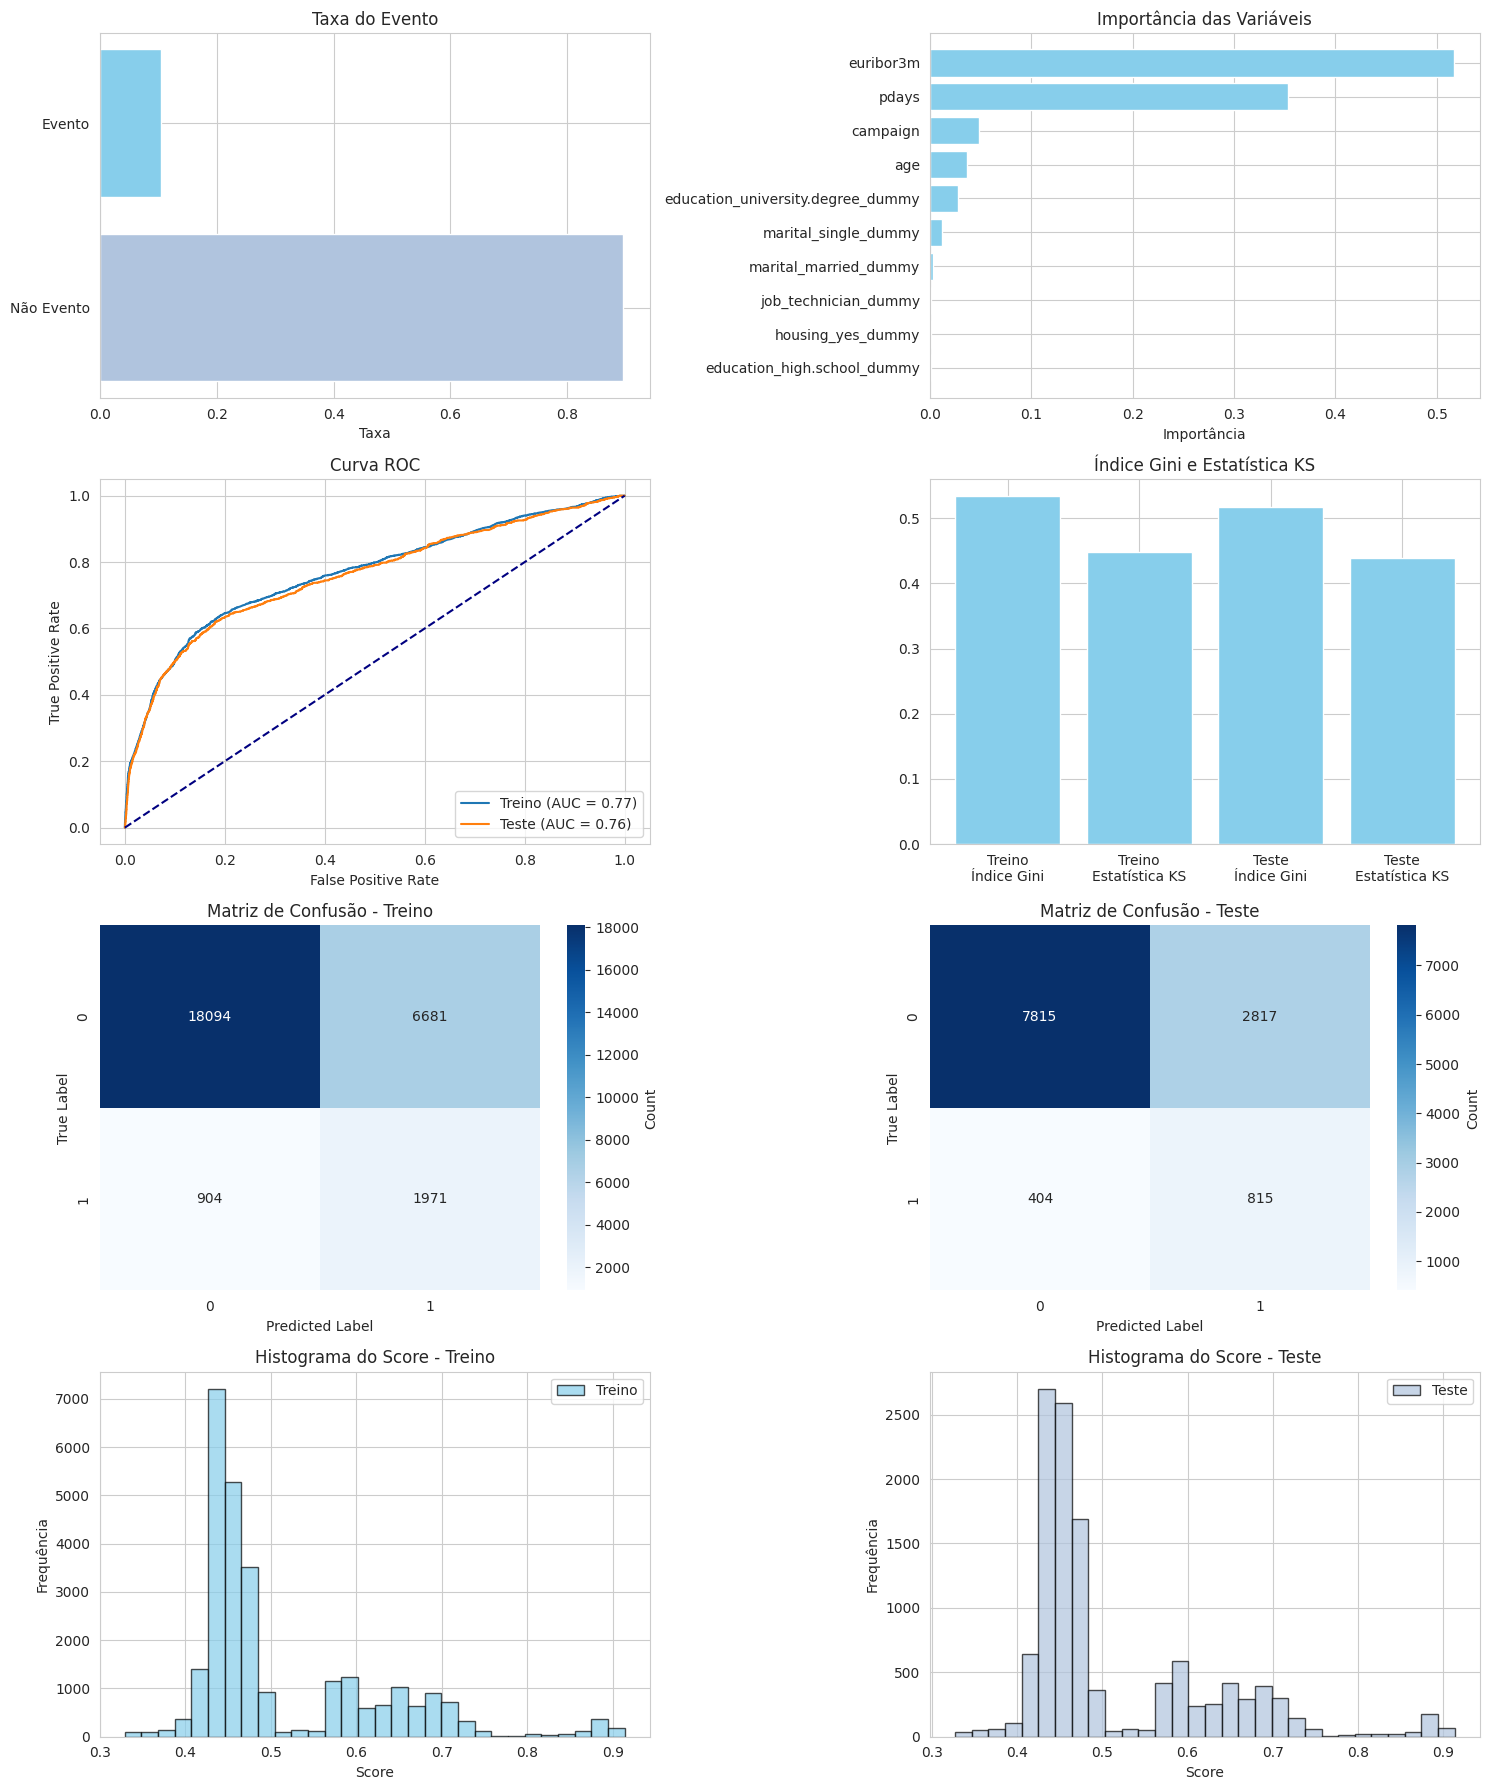

In [ ]:
# Visualizando as métricas

plot_metrics(rf_opt, X_train, y_train, X_test, y_test)

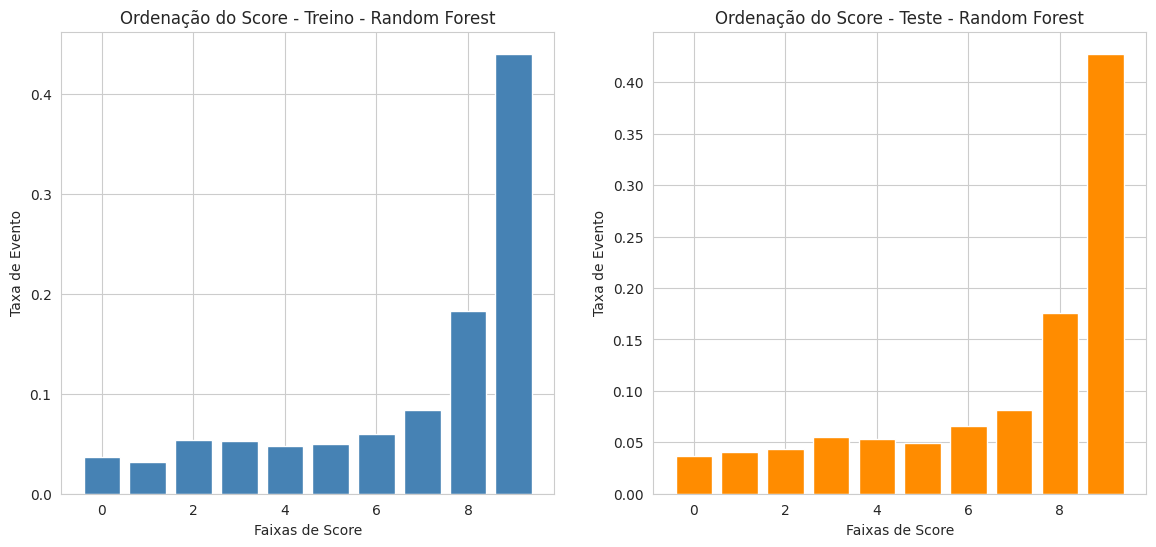

In [ ]:
# Visualizando a ordenação do score
ordena_score(rf_opt, 'Random Forest', X_train, X_test, y_train, y_test, n_bins=10)

#Evaluation

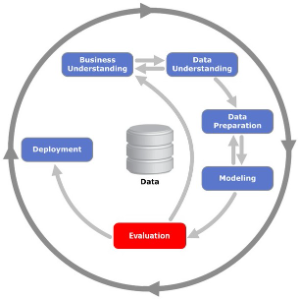

Reavaliando o modelo do ponto de vista do negócio, observa-se que:

<br>

**Taxa de evento:**

  Mantém a proporção do conjunto de dados inicial, que é de aproximadamente 10.4% de evento (saída de target igual a 1 - prepensão à compra)

<br>

**Importância das variáveis:**

As features 'euribor3m' e 'pdays' assumiram a posição de features mais relevantes. Dessa forma, é possível dar continuidade com a produtização do modelo.

<br>

**Métricas do modelo nos dados de teste**:
Valor da principal métrica de avaliação:
* Recall: 0.79

Houve ganho de performance do modelo em relaçao ao Recall.

<br>

**Ordenação do score**:

Os scores não possuem ordenação visível. Porém, do ponto de vista do negócio, será priorizada a avaliação da métrica recall.

<br>

**Aprovação do modelo:**

As métricas e informações de desempenho observadas acima atendem aos requisitos do negócio e validam o modelo para produtização.


#Deployment

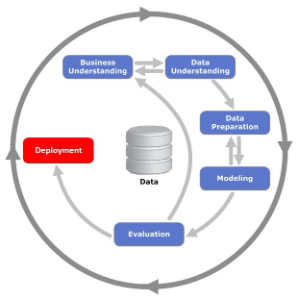

Nesta etapa, serão exportados todos os artefatos utilizados no modelo, além de todas as listas de features selecionadas necessárias para a escoragem de novos dados.

###Exportando artefatos

In [ ]:
# Último dataprep
dataprep = dataprep_05

# Nome do modelo
model = rf_opt

# Exporta o modelo
with open('model.pkl', 'wb') as f:
    pickle.dump(rf_opt, f)

# Exporta lista das features orginais selecionadas
with open('features.pkl', 'wb') as f:
    pickle.dump(lista, f)

# Exporta lista da Feature Importance
with open('features_fs.pkl', 'wb') as f:
    pickle.dump(lista_fs_importance, f)

# Exporta dicionário de valores para imputação
with open('inputs_miss.pkl', 'wb') as f:
    pickle.dump(dataprep.list_miss_input, f)

# Exporta lista de variáveis submetidas ao OneHotEncoder
with open('list_onehotencoder.pkl', 'wb') as f:
    pickle.dump(dataprep.list_var_OneHotEncoder, f)

# Objeto OneHotEncoder
with open('encoder.pkl', 'wb') as f:
    pickle.dump(dataprep.one_hot_enc, f)

###Importando artefatos

In [ ]:
# Abrindo os arquivos para teste

# Importa o modelo
with open('model.pkl', 'rb') as f:
    modelo = pickle.load(f)

# Importa lista das features orginais selecionadas
with open('features.pkl', 'rb') as f:
    variaveis = pickle.load(f)

# Importa dicionário de valores para imputação
with open('inputs_miss.pkl', 'rb') as f:
    valores_imputacao = pickle.load(f)

# Importa lista da Feature Importance
with open('features_fs.pkl', 'rb') as f:
    variaveis_selecionadas = pickle.load(f)

# Importa lista de variáveis submetidas ao OneHotEncoder
with open('list_onehotencoder.pkl', 'rb') as f:
    lista_encoder = pickle.load(f)

# Importa objeto OneHotEncoder
with open('encoder.pkl', 'rb') as f:
    one_hot_encoder = pickle.load(f)


###Escoragem de tabela

In [ ]:
# Tabela a ser escorada
abt_new = abt_00.copy()

#Backup da coluna de ID
bkp_id = abt_new['ID']

# Lista das features utilizadas
abt_new = abt_new[variaveis]

# Prenchimento de missing
abt_new = abt_new.fillna(value=abt_new)

# Aplicando o OneHotEncoder (Lembrar de aplicar o sufixo '_dummy')
encoded_data = one_hot_encoder.transform(abt_new[lista_encoder])
encoded_cols = one_hot_encoder.get_feature_names_out(lista_encoder)
encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols+'_dummy', index=abt_new.index)
abt_new = pd.concat([abt_new.drop(lista_encoder, axis=1), encoded_df], axis=1)

# Aplicando a lista de features selecionadas
abt_new = abt_new[variaveis_selecionadas]

# Fazendo predições
y_pred = modelo.predict(abt_new)

# Agregando os ID's à tabela
abt_new['ID'] = bkp_id

# Agregando as predições à tabela
abt_new['Classe'] = y_pred

# Salvando a tabela escorada
abt_new.to_csv('tabela_escorada.csv', index=False)

###Deploy AWS e Streamlit

A partir deste ponto, todos os artefatos serao salvos em máquina local e utilizados na laboração do deploy do modelo.


Os códigos serão desenvolvidos a partir da IDE Visual Studio Code.


O o modelo será alocado numa instancia da AWS Lambda, constituindo uma arquitetura serveless.


A função é ativada a partir de um endpoint, acessado via API.


A interface onde o usuário poderá imputar os dados para fazer novas prediçoes será desevolvida através da biblioteca Streamlit.


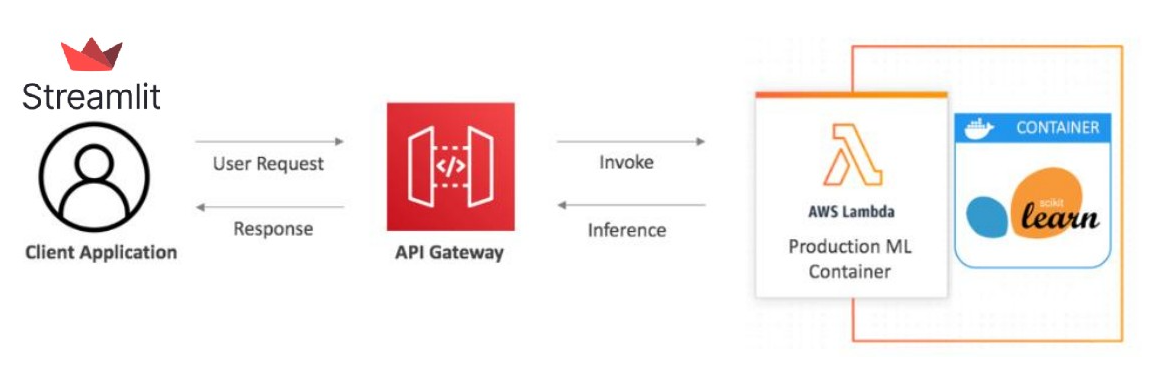

End-point da API:


> `https://o4z6kok940.execute-api.us-east-2.amazonaws.com/Prod/classify_digit/`



Teste da API

In [ ]:
# Criando umbody fictício
body =[
        {"params": "35,1000,500,100,1111,100,100,1,100,80,1"},
        {"params": "0,0,0,0,0,0,0,0,0,0,0"}
      ]

# Exibindo
body

[{'params': '35,1000,500,100,1111,100,100,1,100,80,1'},
 {'params': '0,0,0,0,0,0,0,0,0,0,0'}]

In [ ]:
# Fazendo requisição para a API

import requests
import json


url = "https://o4z6kok940.execute-api.us-east-2.amazonaws.com/Prod/classify_digit/"

resposta = requests.post(url, json=body)
results = resposta.json()
results

{'predicoes': [0, 1],
 'prob_classe_0': [0.6327939080394457, 0.1196027520684165],
 'prob_classe_1': [0.36720609196055426, 0.8803972479315839]}

Gerando amostrar para teste com Streamlit

In [ ]:
# Amostra 1: 5 observações
amostra1 = abt_00.sample(n=5, random_state=1)
amostra1.to_csv('amostra1.csv' , index=False)

# Amostra 2: 100 observações
amostra2 = abt_00.sample(n=100, random_state=2)
amostra2.to_csv('amostra2.csv' , index=False)

# Amostra 3: 300 observações
amostra3 = abt_00.sample(n=300, random_state=3)
amostra3.to_csv('amostra3.csv' , index=False)

In [ ]:
# Visualizando
amostra3.sample(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,ID
33534,28,management,single,university.degree,no,yes,no,cellular,may,tue,...,999,0,nonexistent,-1.8,92.893,-46.2,1.291,5099.1,no,410a74d1
20457,60,services,married,high.school,unknown,no,no,cellular,aug,tue,...,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,no,6aebbde6
5618,40,admin.,married,university.degree,unknown,yes,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,d6a3cb3f
